<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Indicator" data-toc-modified-id="Indicator-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Indicator</a></span></li><li><span><a href="#Dataloader" data-toc-modified-id="Dataloader-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataloader</a></span></li><li><span><a href="#generate-surface-data" data-toc-modified-id="generate-surface-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>generate surface data</a></span></li><li><span><a href="#生成gif:输入-输出" data-toc-modified-id="生成gif:输入-输出-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>生成gif:输入-输出</a></span></li><li><span><a href="#test-KL-loss" data-toc-modified-id="test-KL-loss-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>test KL loss</a></span></li></ul></div>

# Indicator

In [1]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
class Indicator:
    def __init__(self):
        self.y_true=[]
        self.y_pred=[]
        
    def indicator_cls(self):
        tn, fp, fn, tp=confusion_matrix(self.y_true,self.y_pred ).ravel()
        POD=tp/(tp+fn)
        FAR=fp/(tp+fp)
        CSI=tp/(tp+fn+fp)
        return {'POD':POD,'FAR':FAR,'CSI':CSI}
    
    def indicator_reg(self):
        conv=np.cov([self.y_true,self.y_pred])
        CC=conv[0,1]/np.sqrt(conv[0,0]*conv[1,1])
        BIAS=np.sum(np.array(self.y_pred)-np.array(self.y_true))/np.sum(self.y_true)
        MSE=np.mean((np.array(self.y_pred)-np.array(self.y_true))**2)
        return {'CC':CC,'BIAS':BIAS,'MSE':MSE}
    
    def reset(self):
        self.y_true=[]
        self.y_pred=[]

In [3]:
indicator=Indicator()

y_true=np.array([0,1,0,1])
y_pred=np.array([0,0,0,1])
indicator.y_true.extend(y_true.tolist())
indicator.y_pred.extend(y_pred.tolist())
print(indicator.indicator_cls())
indicator.reset()

y_true=np.random.rand(10)
y_pred=np.random.rand(10)
indicator.y_true.extend(y_true.tolist())
indicator.y_pred.extend(y_pred.tolist())
print(indicator.indicator_reg())

{'POD': 0.5, 'FAR': 0.0, 'CSI': 0.5}
{'CC': -0.3734995001892597, 'BIAS': 0.05636903177513183, 'MSE': 0.19665896141201028}


# Dataloader

In [1]:
from torch.utils.data import Dataset
from datetime import date
from datetime import timedelta
import numpy as np
import random
import tqdm
import os

GOSE=np.load('/usr/commondata/weather/dataset_release/IR_dataset_QingHua/X_train_hourly.npz')
StageIV=np.load('/usr/commondata/weather/dataset_release/IR_dataset_QingHua/Y_train_hourly.npz')
GOSE=GOSE['arr_0']
StageIV=StageIV['arr_0']

In [ ]:
GOSE_toy=GOSE[:100]
StageIV_toy=StageIV[:100]
np.savez('/usr/commondata/weather/dataset_release/IR_dataset_QingHua/X_train_hourly_toy.npz',GOSE_toy)
np.savez('/usr/commondata/weather/dataset_release/IR_dataset_QingHua/Y_train_hourly_toy.npz',StageIV_toy)

# generate surface data

In [2]:
import torch
import numpy as np
import random

def SetSeed(seed):
    """function used to set a random seed
    Arguments:
        seed {int} -- seed number, will set to torch, random and numpy
    """
    SEED = seed
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    random.seed(SEED)
    np.random.seed(SEED)

SetSeed(2020)

In [3]:
from Identification.models.IPEC_model import IPECNet
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from collections import OrderedDict

In [4]:
import Identification.models.Dataloader as DL
import imp
imp.reload(DL)

def test_model(model_path,X,Y,multi_gpu=True,batch_size=1024,step=14):
    ########################load model######################
    model=IPECNet(nc=[1,16,16,32,32],padding_type='zero',norm_layer=nn.BatchNorm2d,task='identification')
    model = torch.nn.DataParallel(model.to('cuda'), device_ids=[0,1,2,3])
    state_dict = torch.load(model_path)['state_dict']
    if multi_gpu:
        model.load_state_dict(state_dict)
    else:
        state_dict = torch.load(model_path)['state_dict']
        # create new OrderedDict that does not contain `module.`
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v

        model.load_state_dict(new_state_dict)
        
    model=model.cuda()
    
    
    #######################generate samples################
    L=len(range(14,375-15,step))**2
    test_data=torch.zeros(L,3,29,29)
    y_true=np.zeros(L)

    N=0
    for i in range(14,375-15,step):
        for j in range(14,375-15,step):
            tmpX=DL.IRDataset.unsafe_crop_center(X,i,j,14,14)
            test_data[N,:,:,:]=tmpX
            y_true[N]=(Y[i,j]>0.1)
            N+=1
    
    #######################get pred###################
    with torch.no_grad():
        pred=[]
        for i in range(0,L//batch_size+1):
            scope=range(i*batch_size,min((i+1)*batch_size,L))
            tmpX=torch.tensor(test_data[scope]).float().cuda()
            tmp_pred=np.argmax(model(tmpX).detach().cpu().numpy(),axis=1)
            pred.append(tmp_pred)

    pred=np.hstack(pred)
    
    return pred,y_true

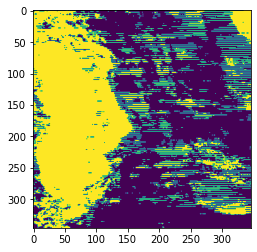

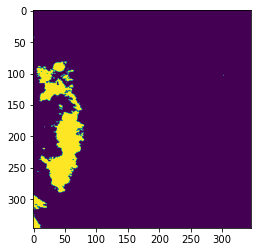

In [12]:
plt.imshow(pred.reshape(346,346))
plt.show()

plt.imshow(y_true.reshape(346,346))
plt.show()

/opt/anaconda3/envs/climate/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


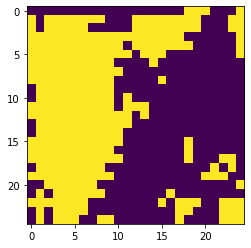

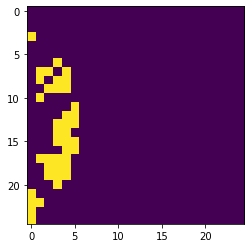

In [23]:
X=torch.tensor(GOSE[45]).float().cuda()
Y=StageIV[45]
pred,y_true=test_model('./Identification/results/like_qinghua/Epoch_31.pth.tar',X=X,Y=Y,step=14)

plt.imshow(pred.reshape(25,25))
plt.show()

plt.imshow(y_true.reshape(25,25))
plt.show()

/opt/anaconda3/envs/climate/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


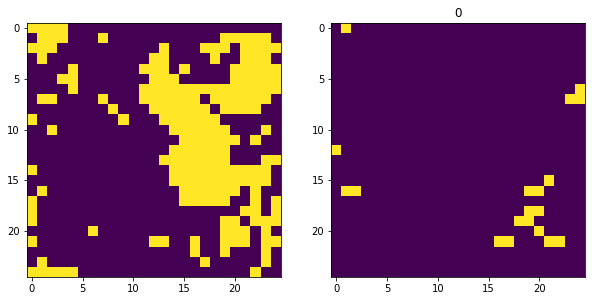

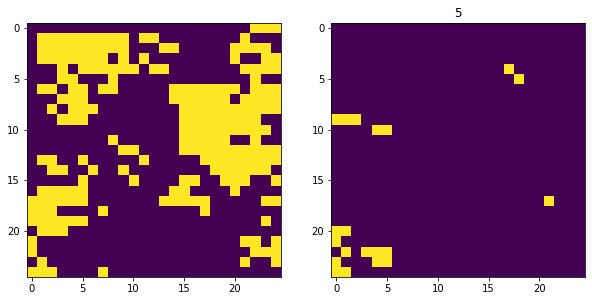

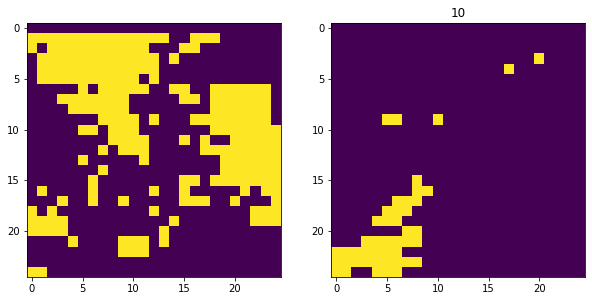

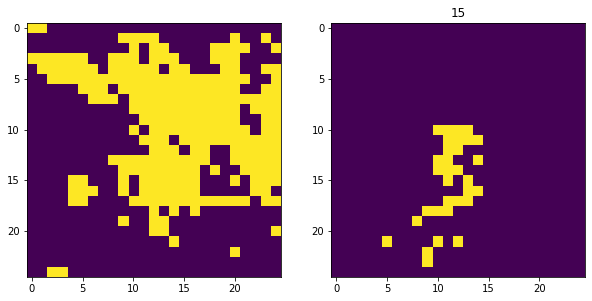

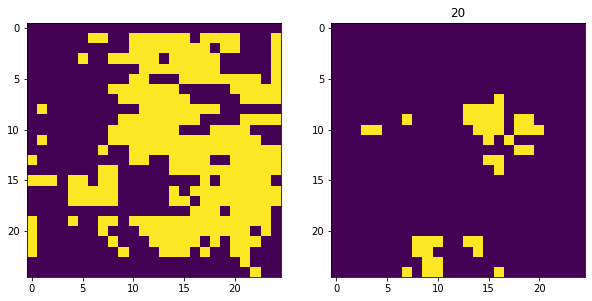

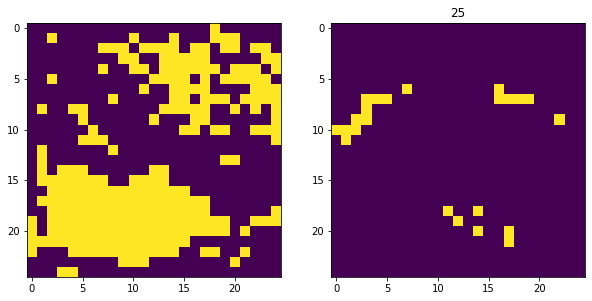

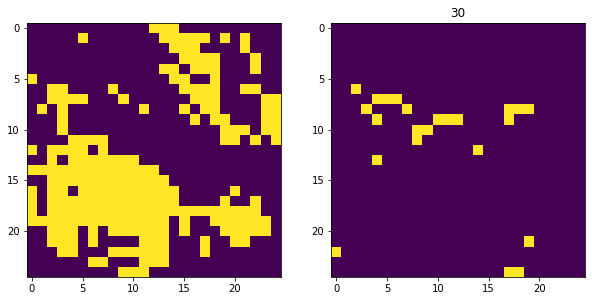

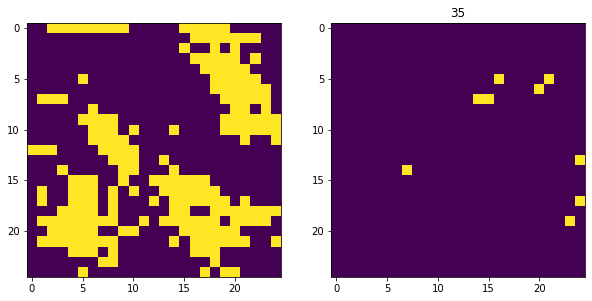

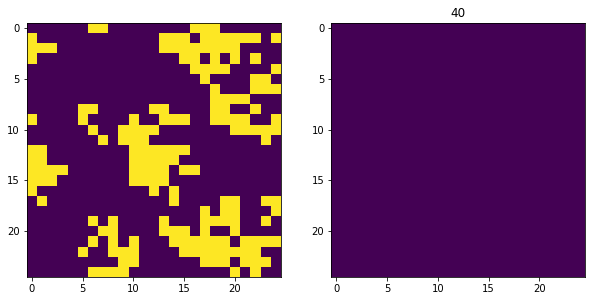

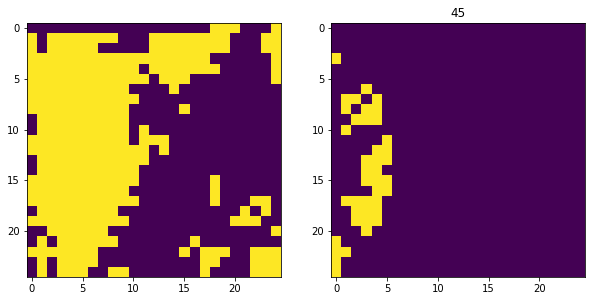

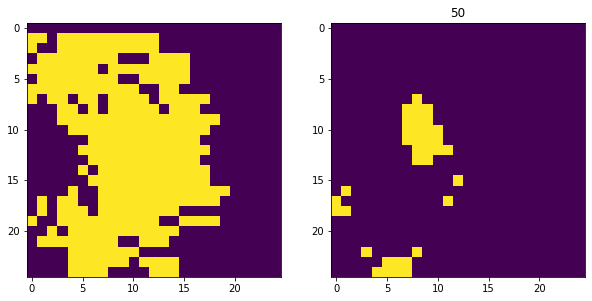

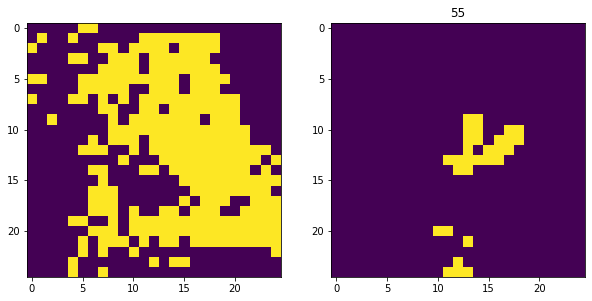

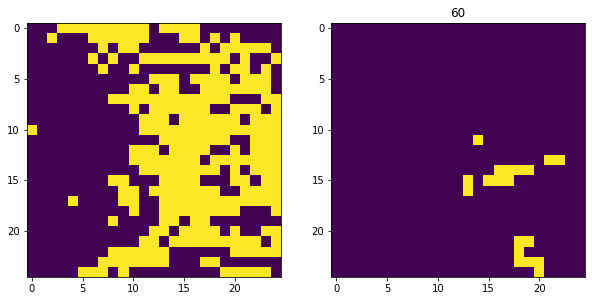

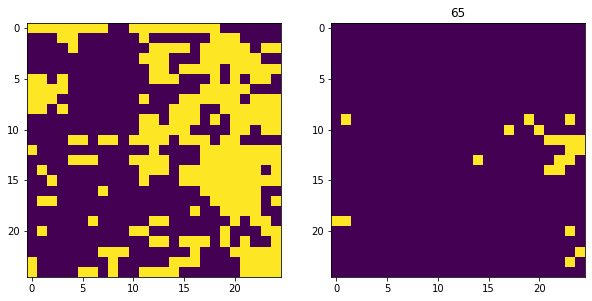

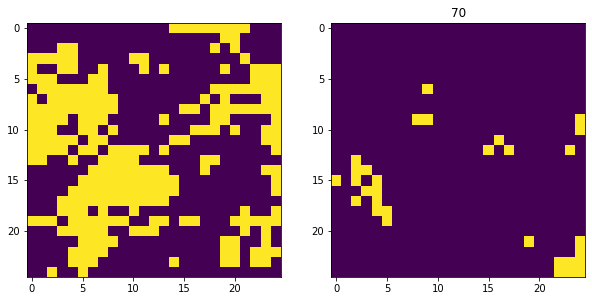

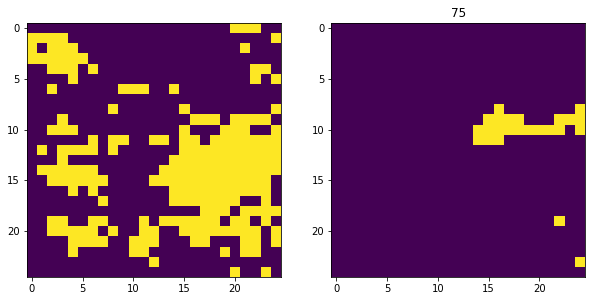

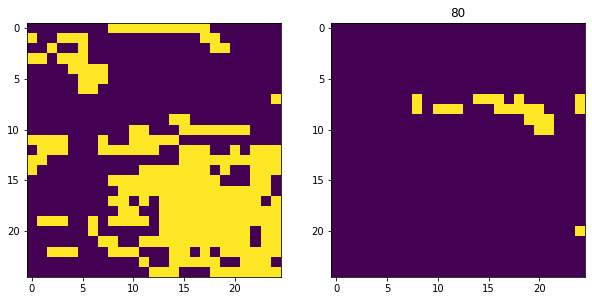

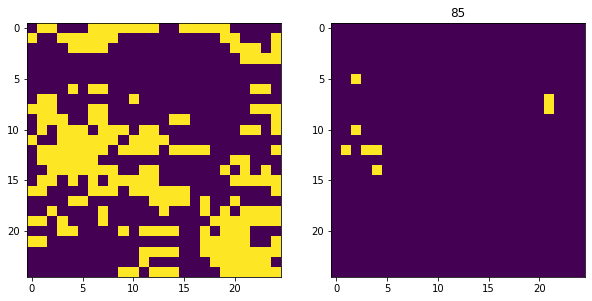

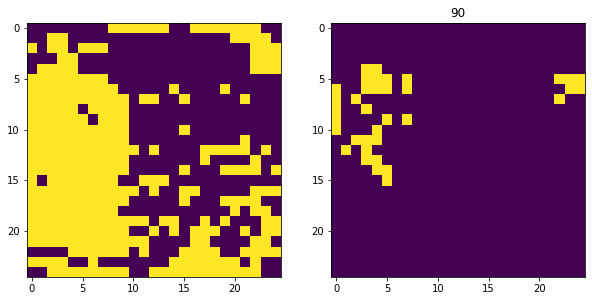

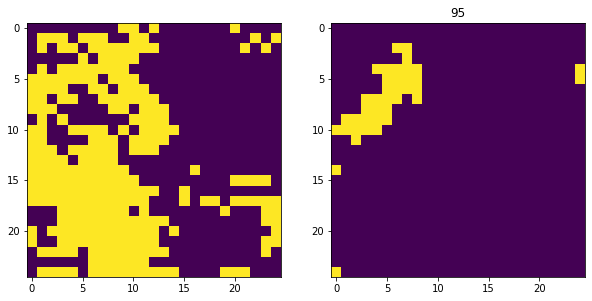

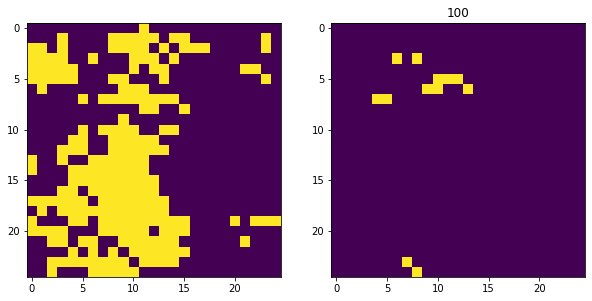

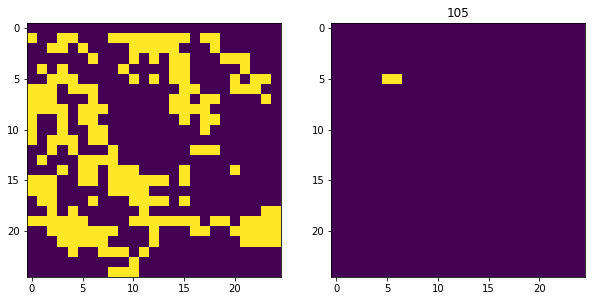

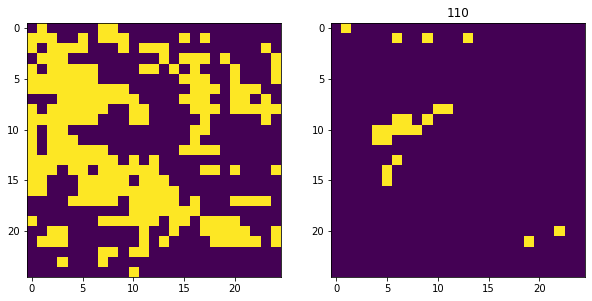

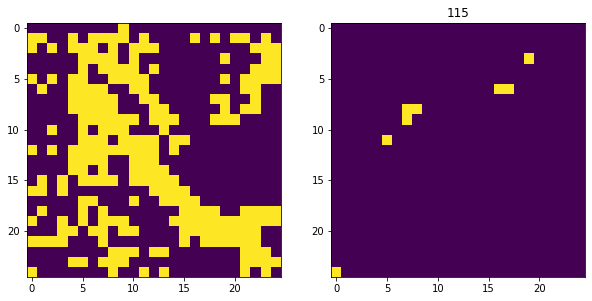

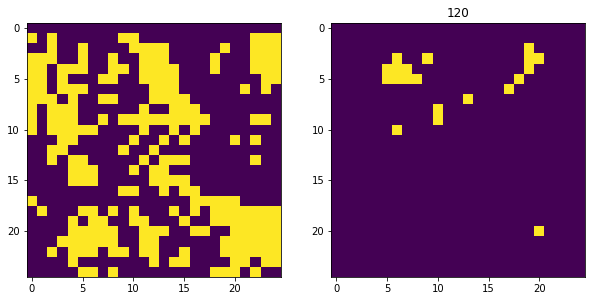

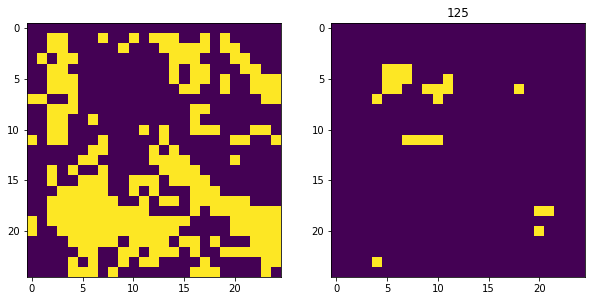

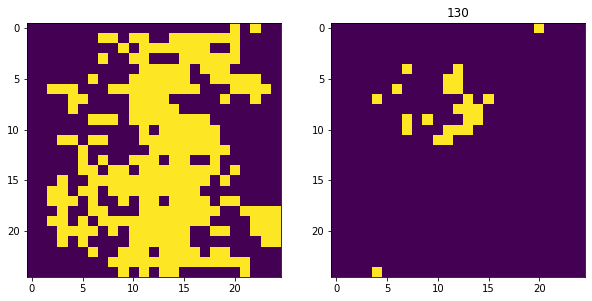

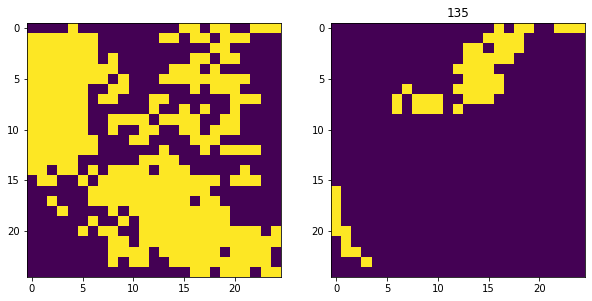

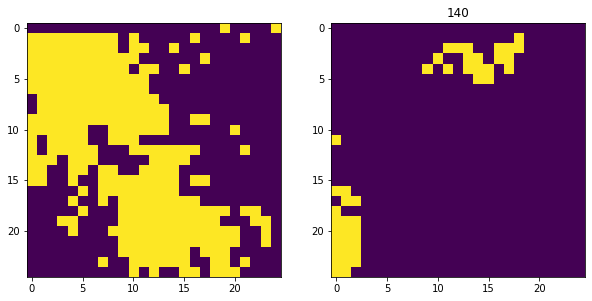

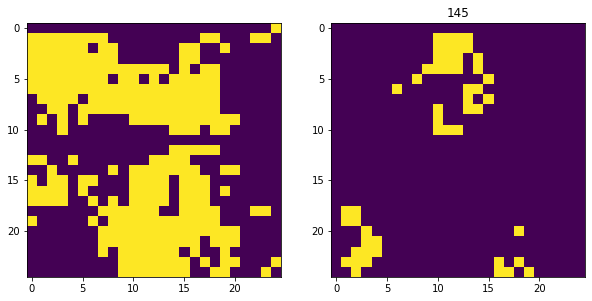

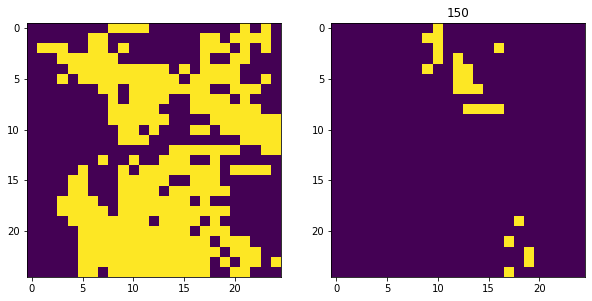

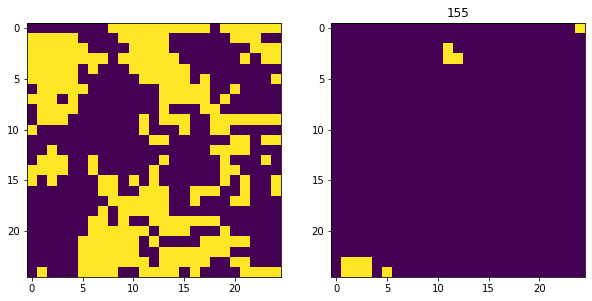

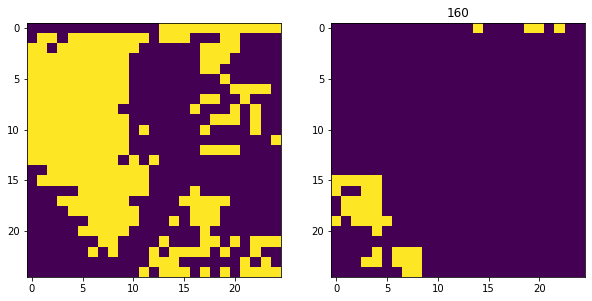

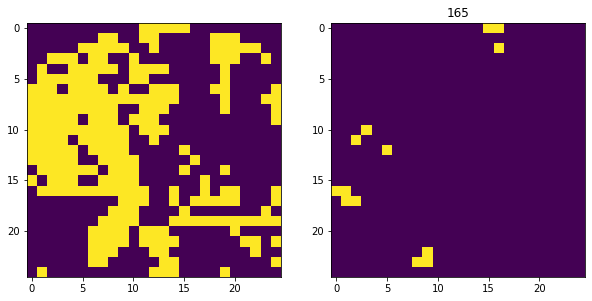

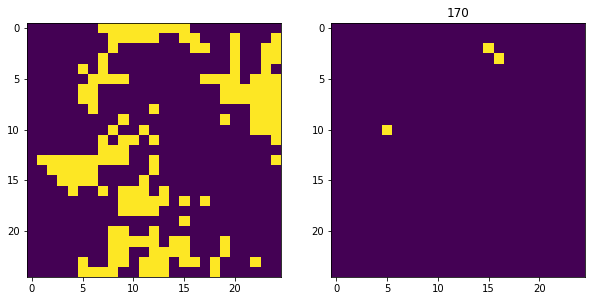

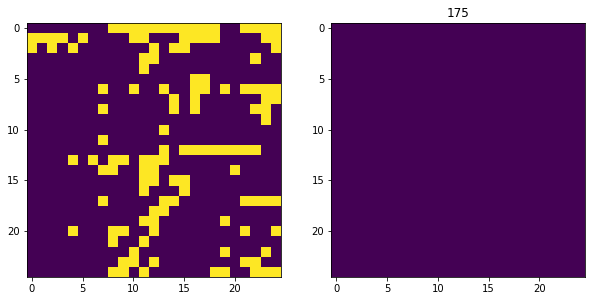

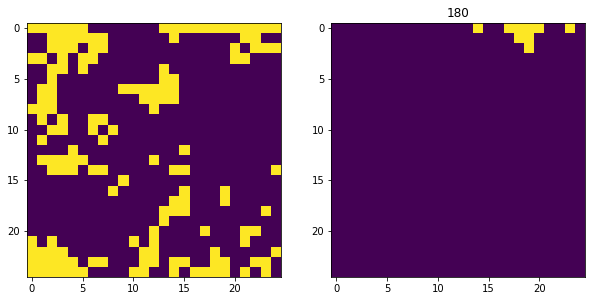

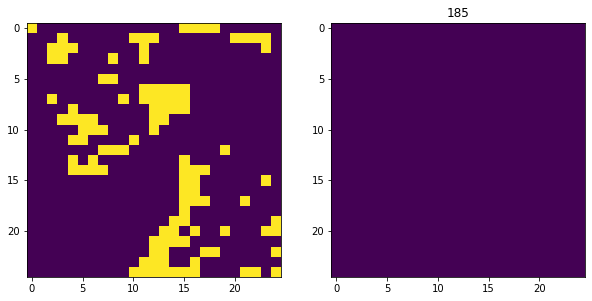

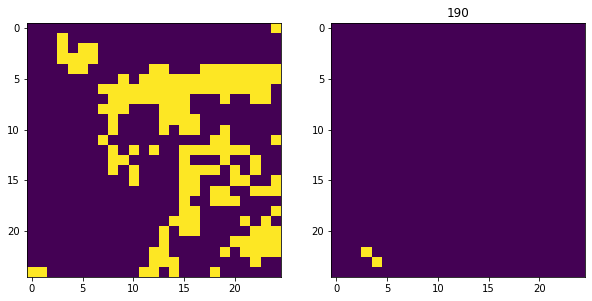

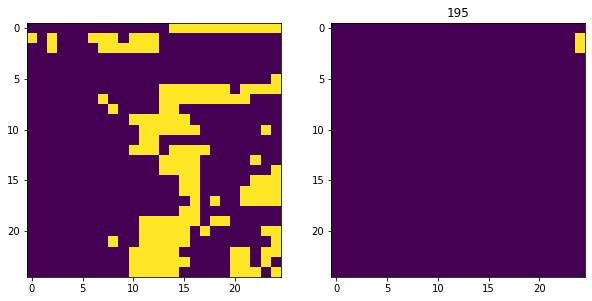

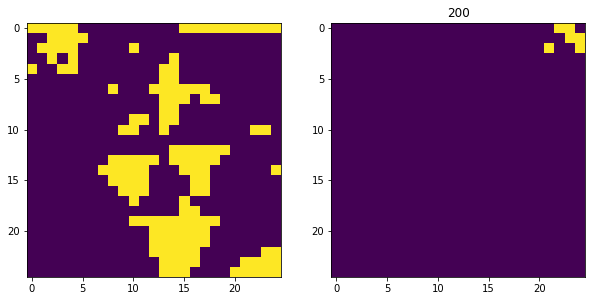

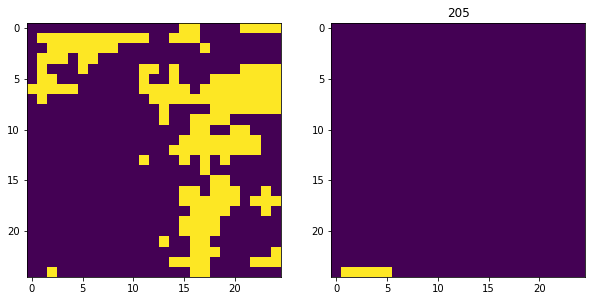

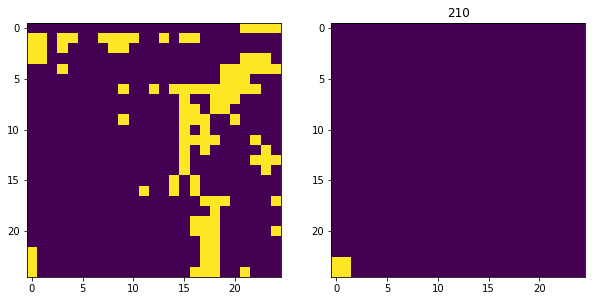

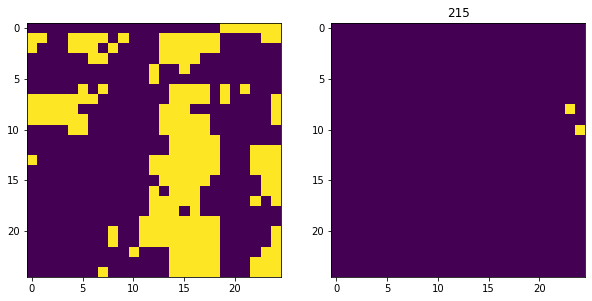

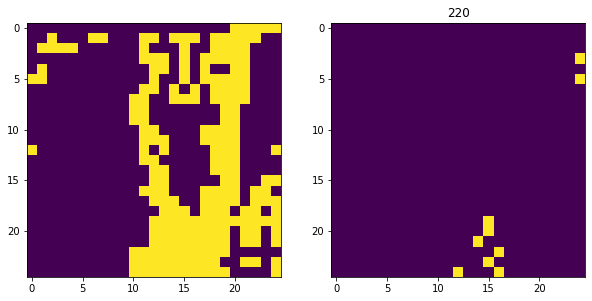

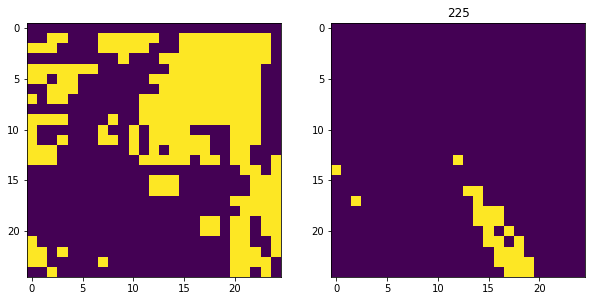

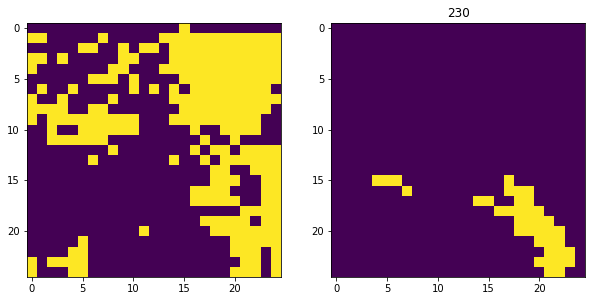

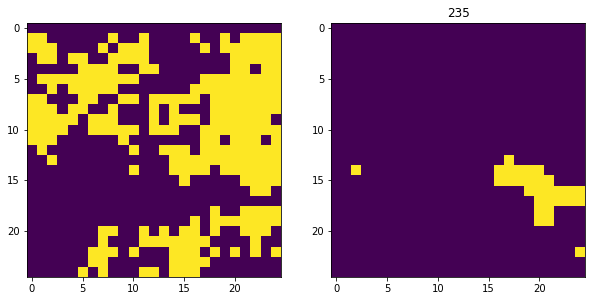

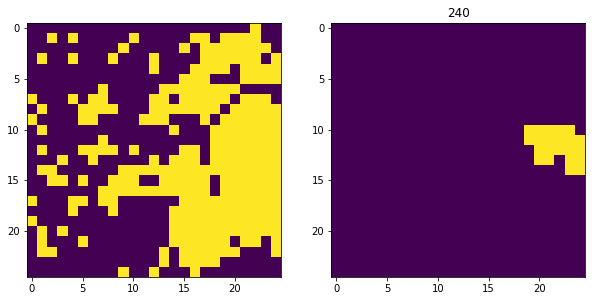

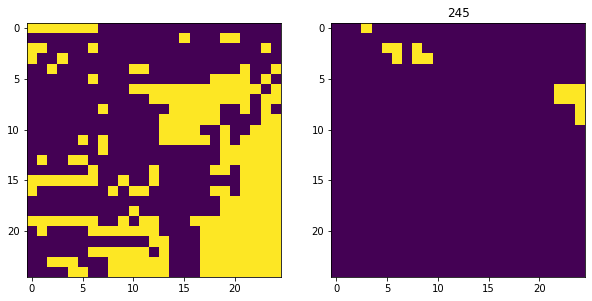

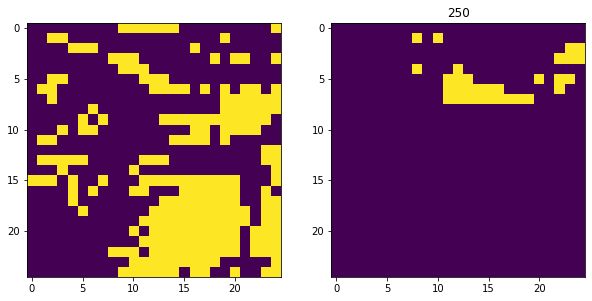

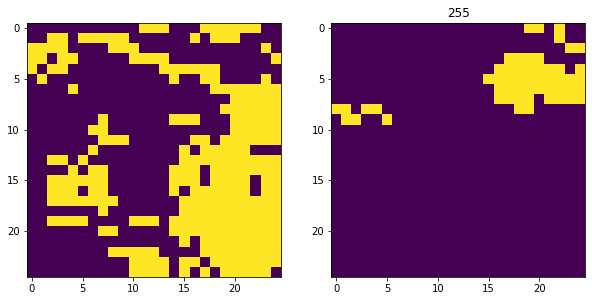

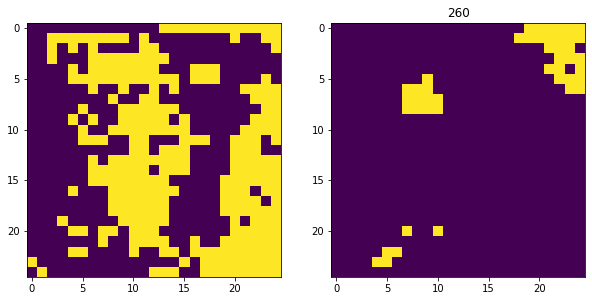

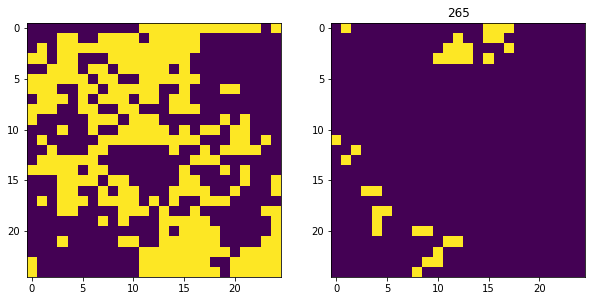

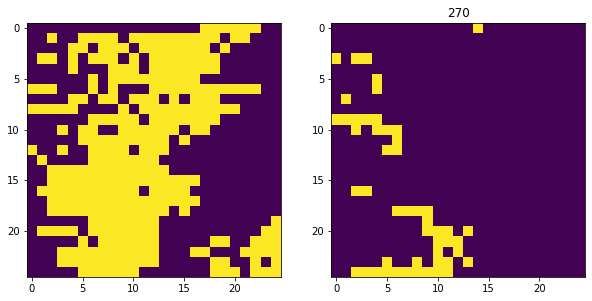

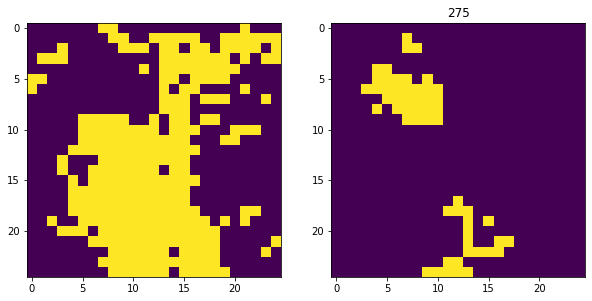

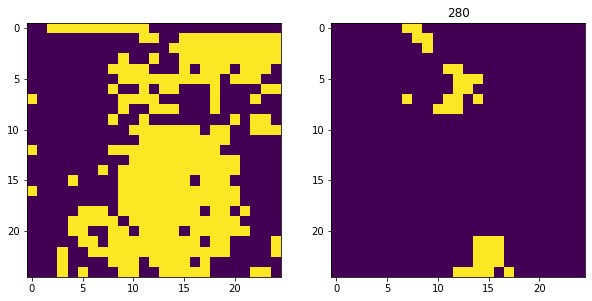

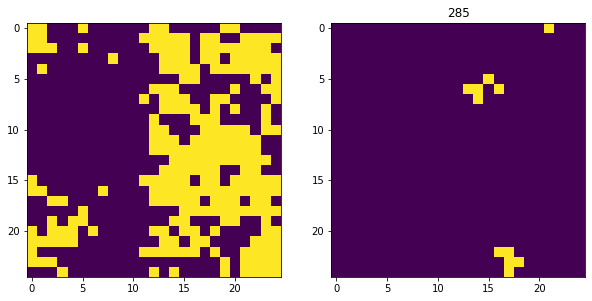

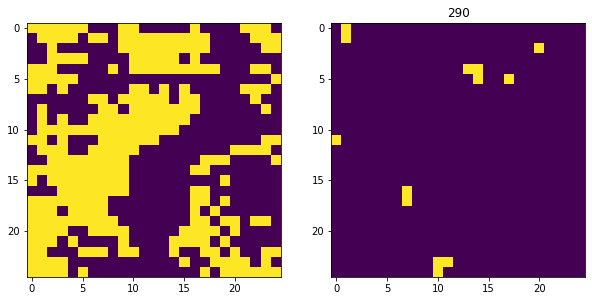

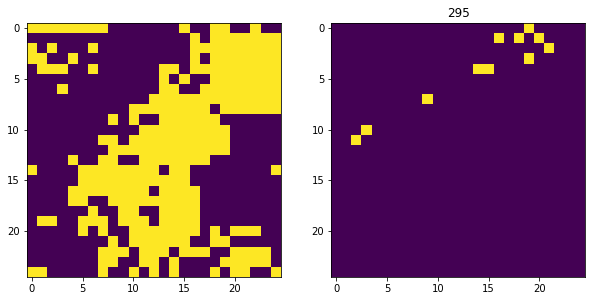

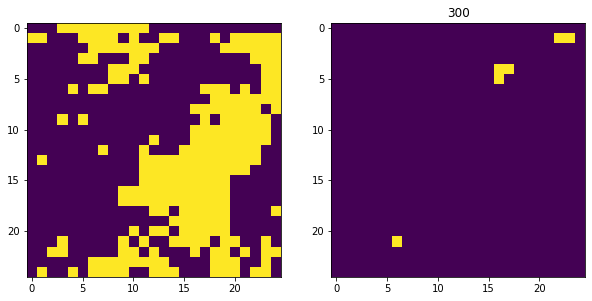

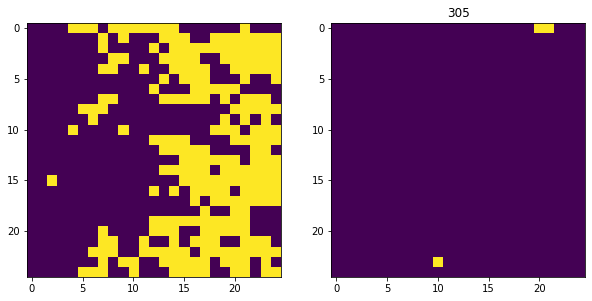

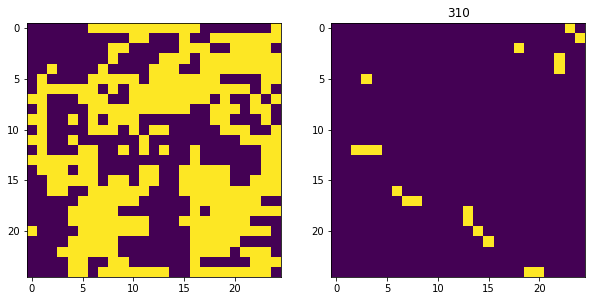

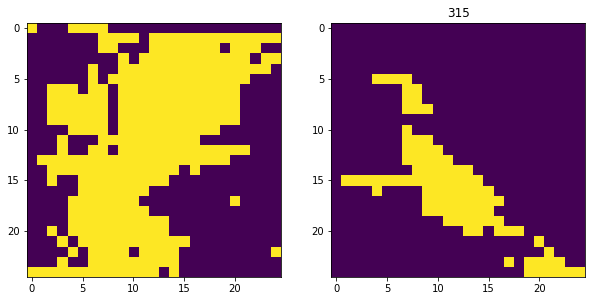

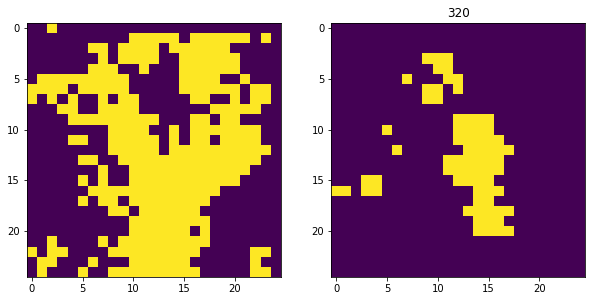

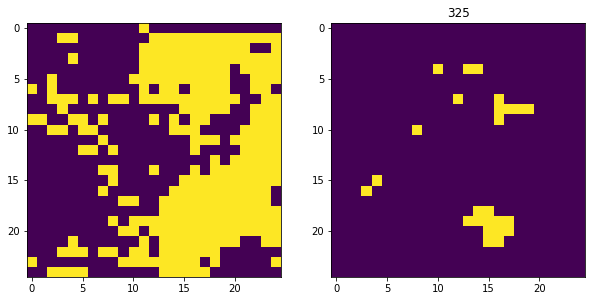

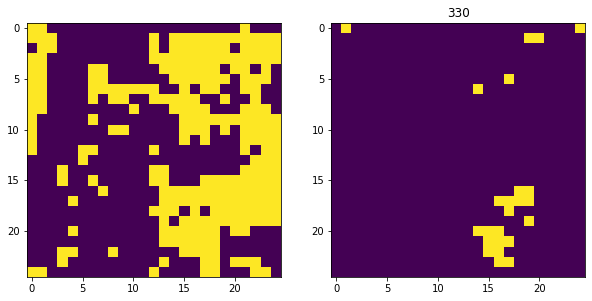

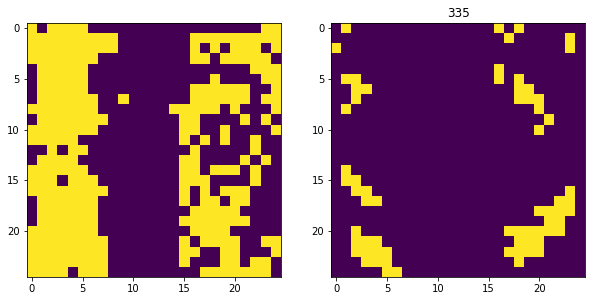

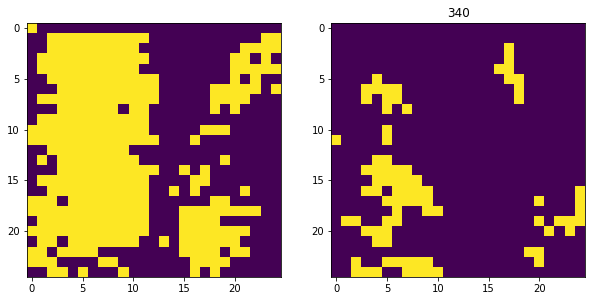

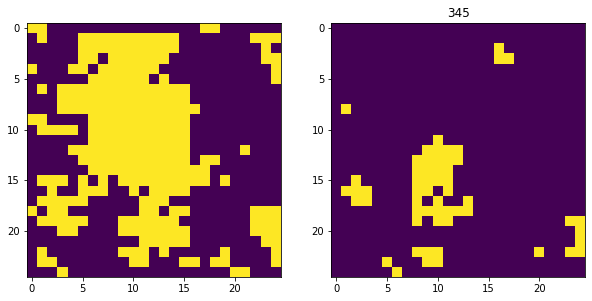

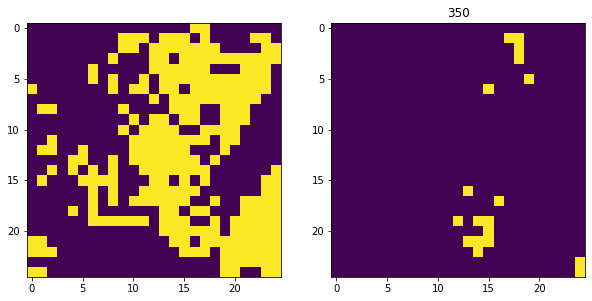

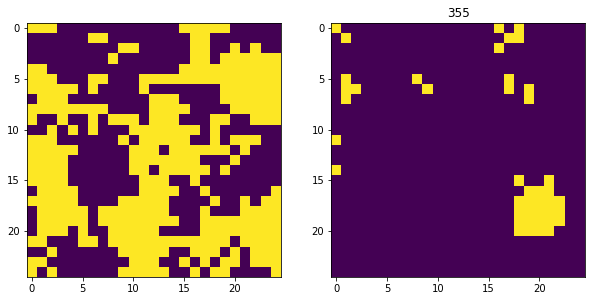

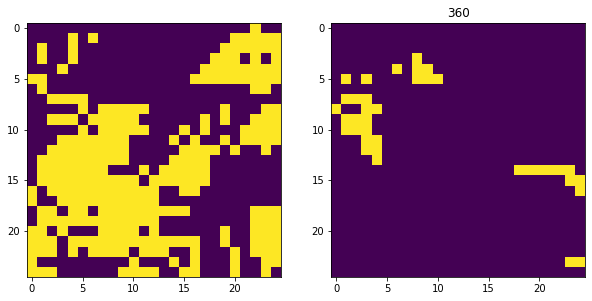

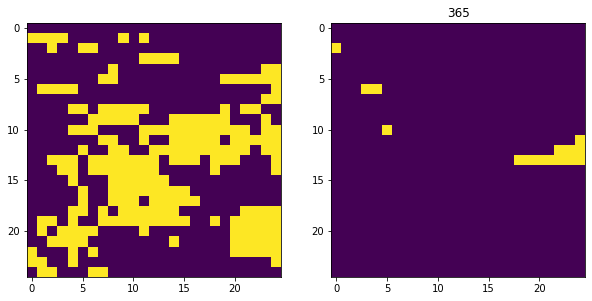

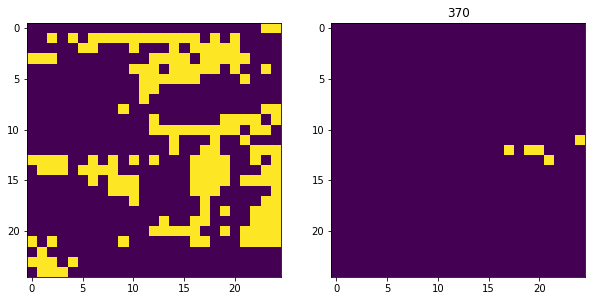

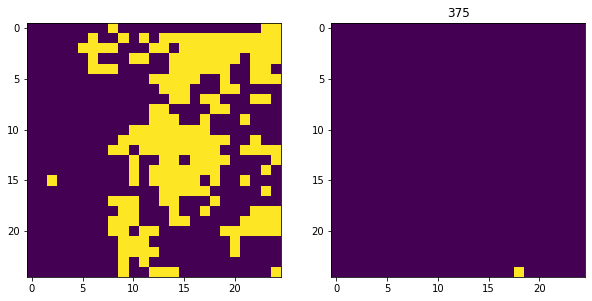

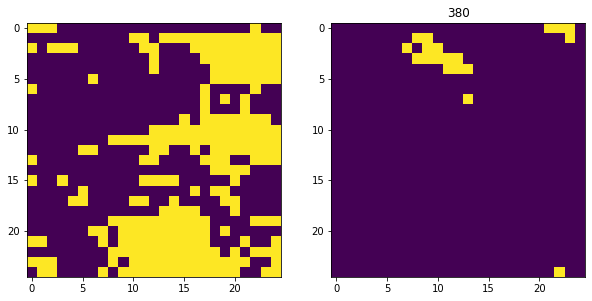

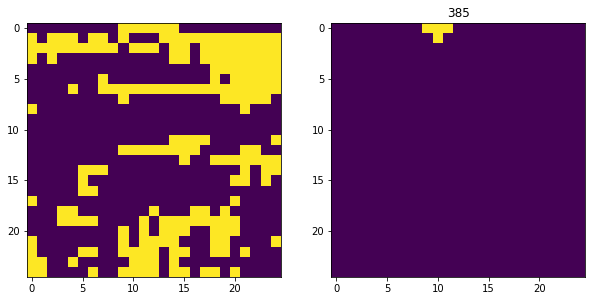

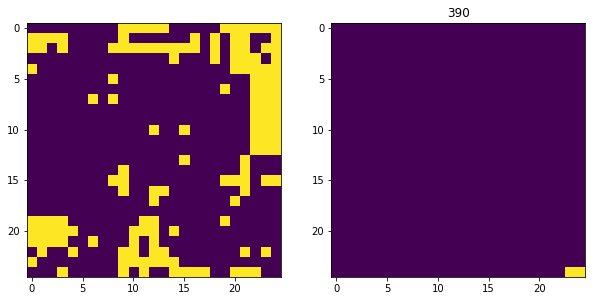

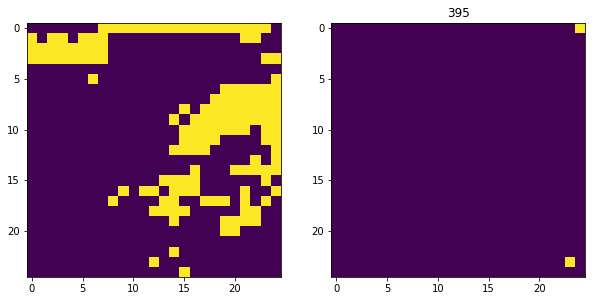

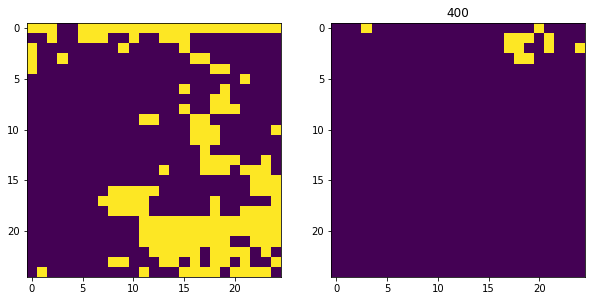

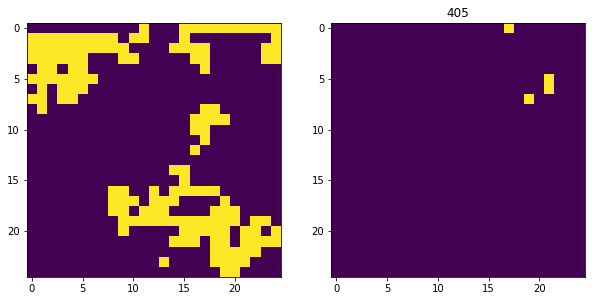

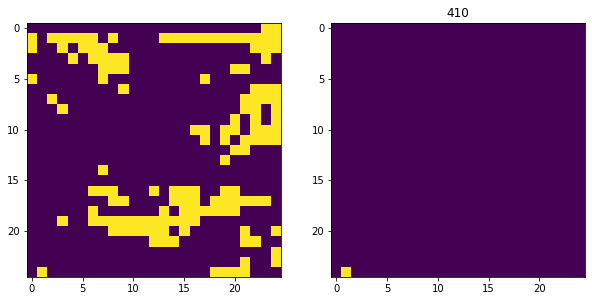

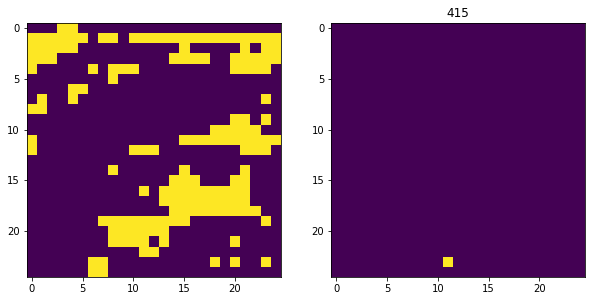

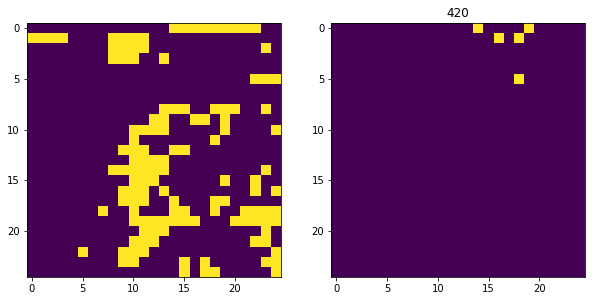

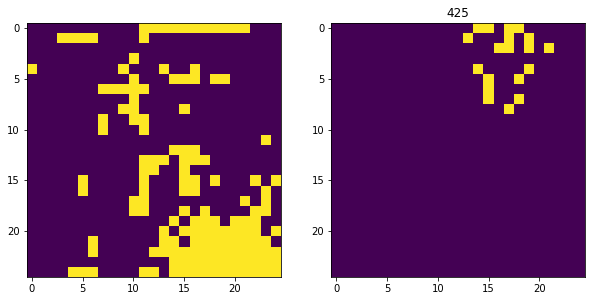

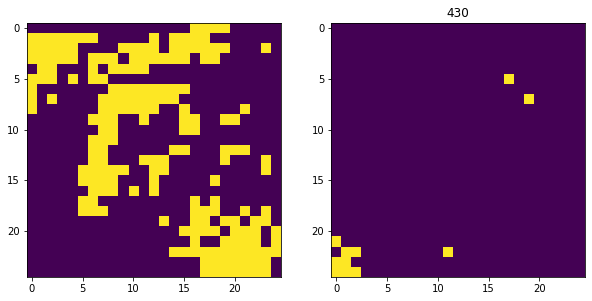

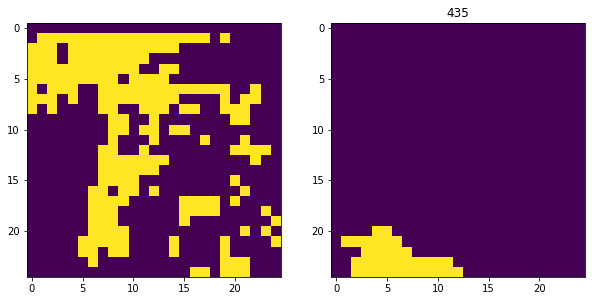

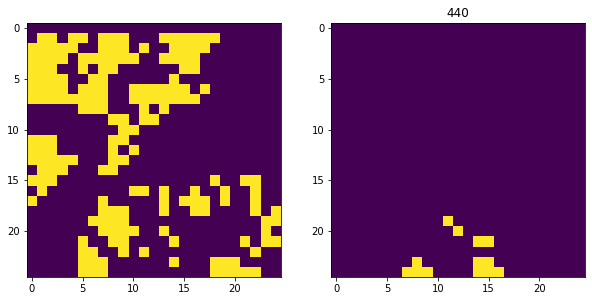

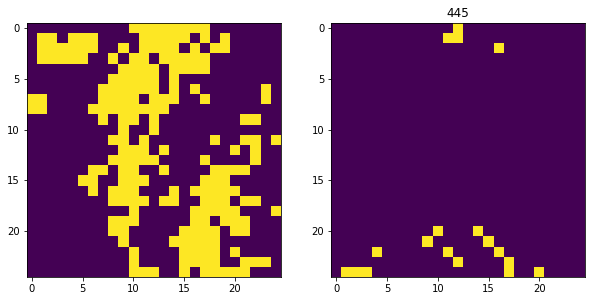

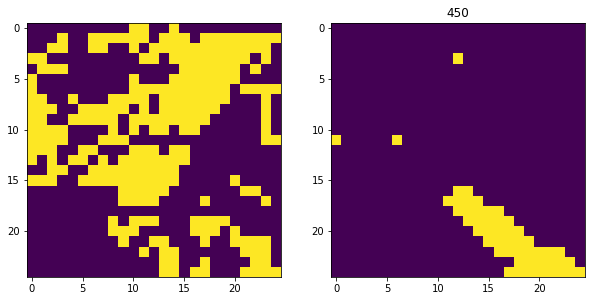

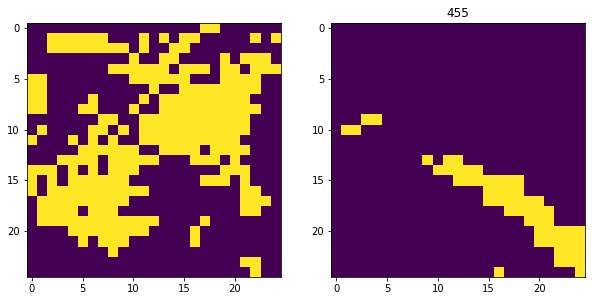

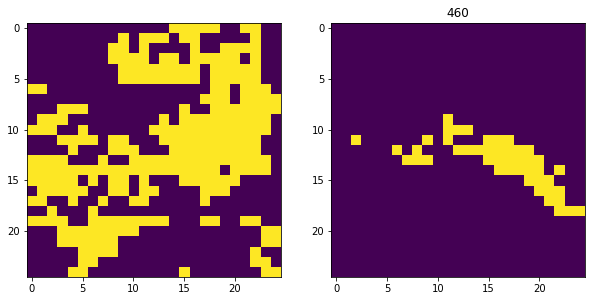

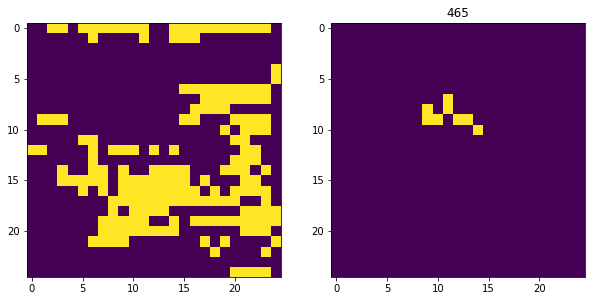

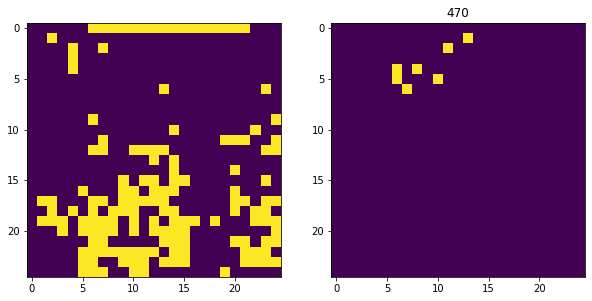

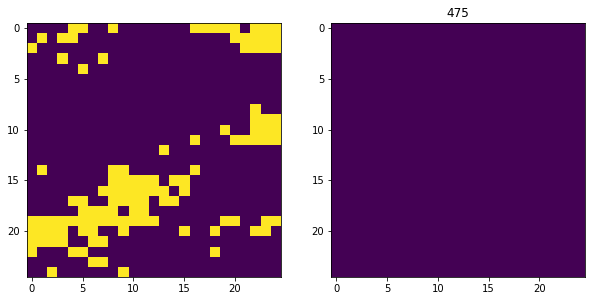

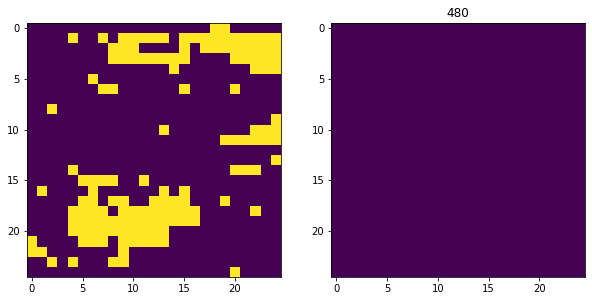

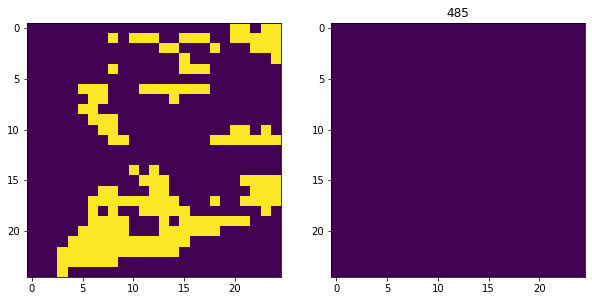

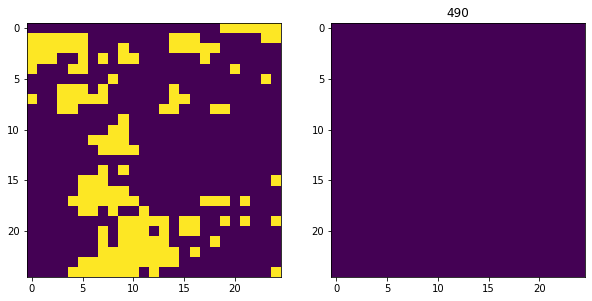

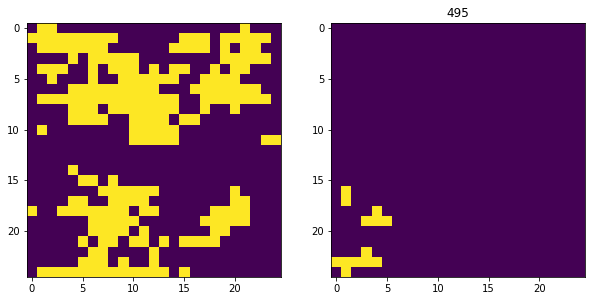

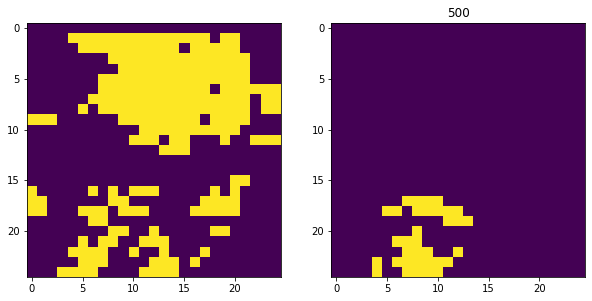

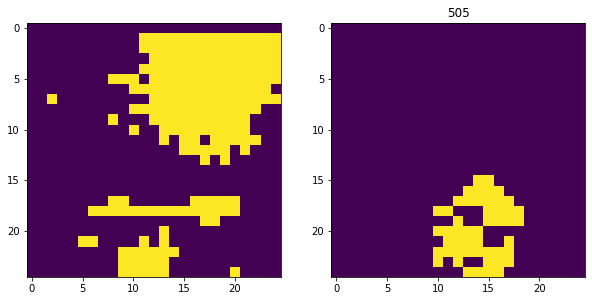

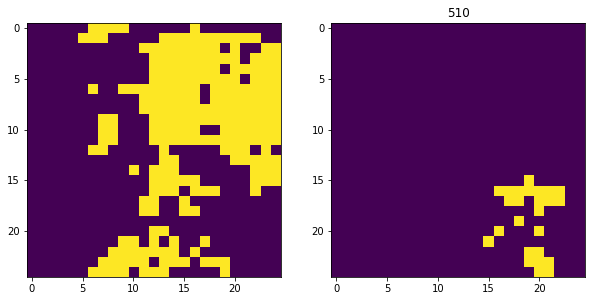

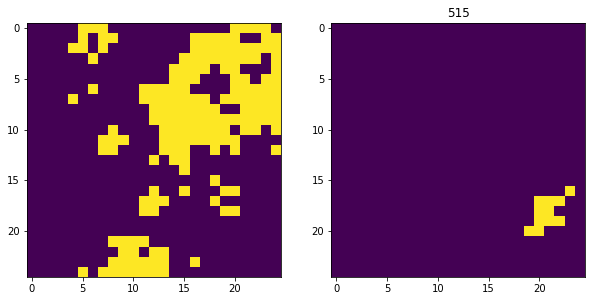

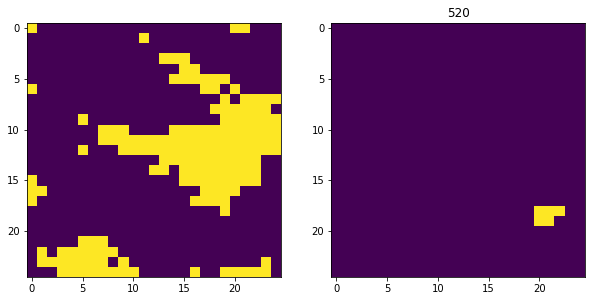

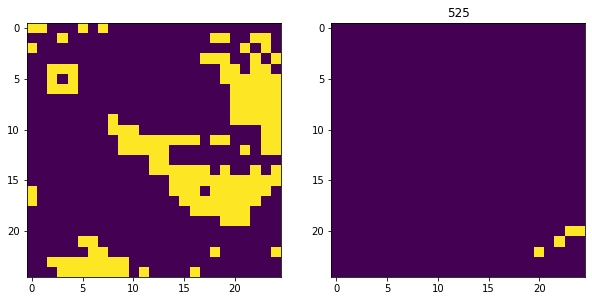

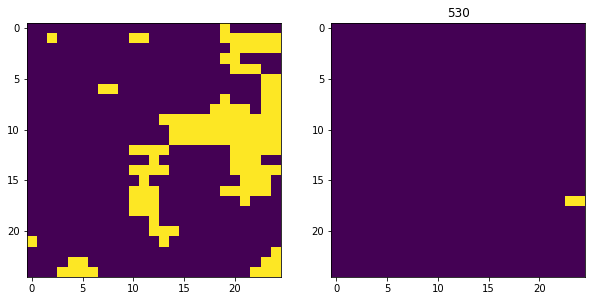

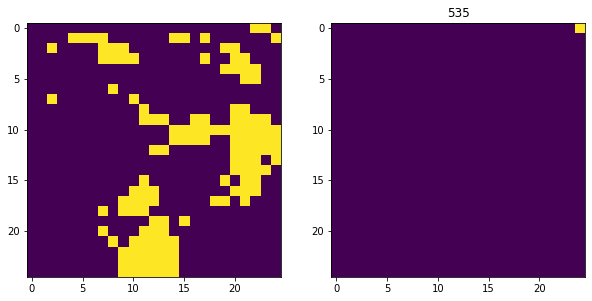

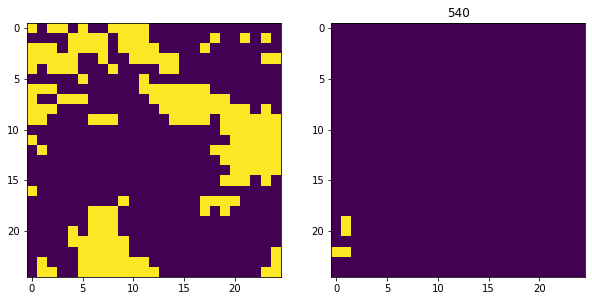

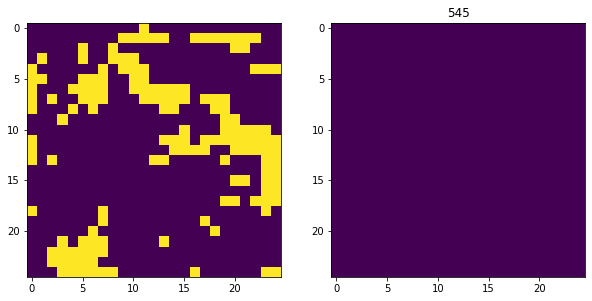

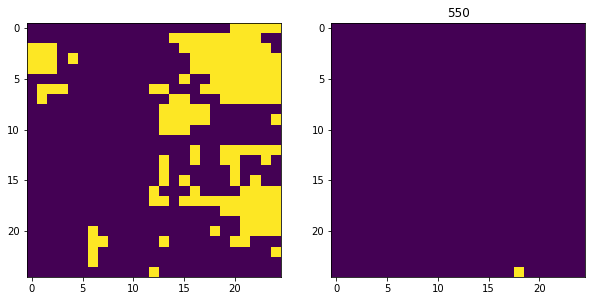

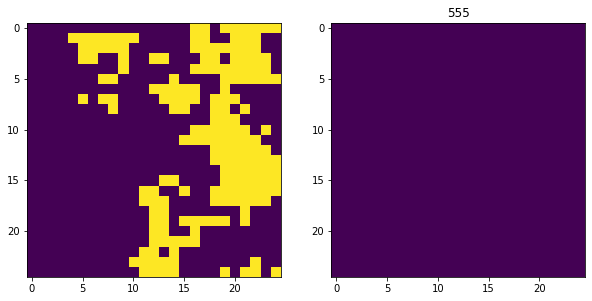

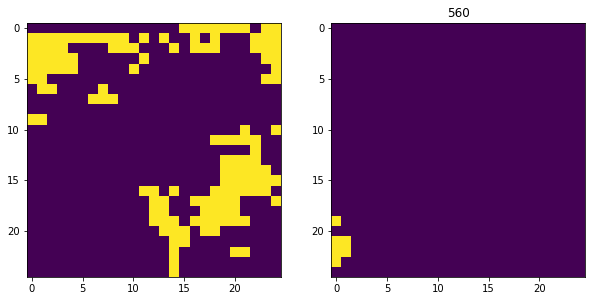

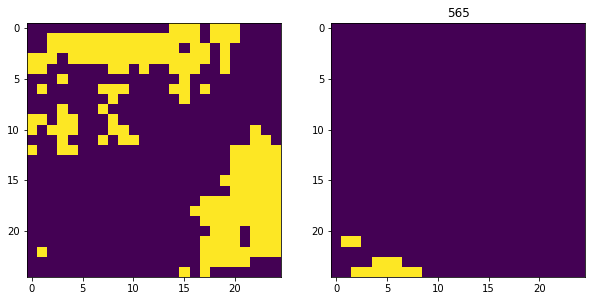

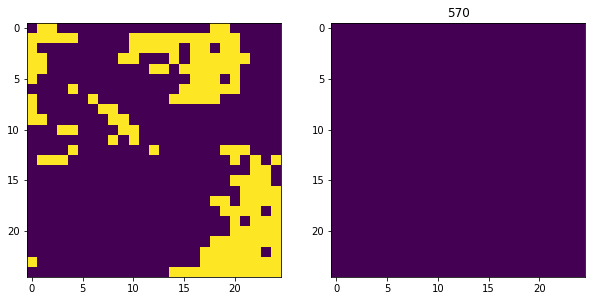

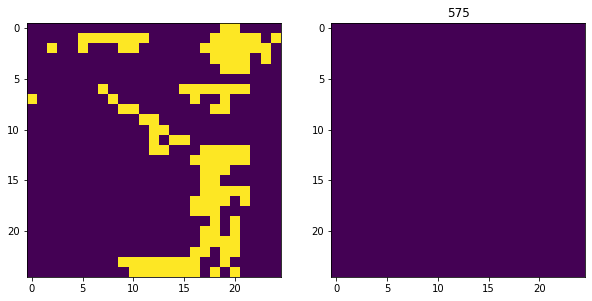

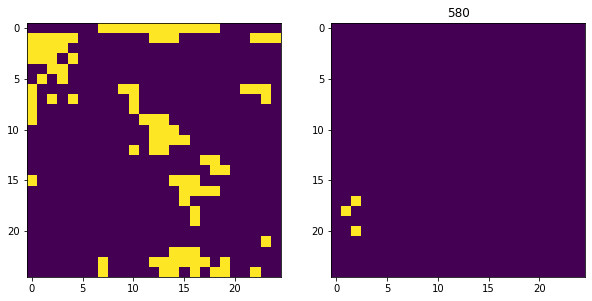

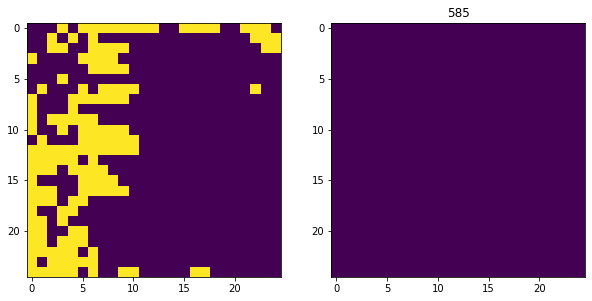

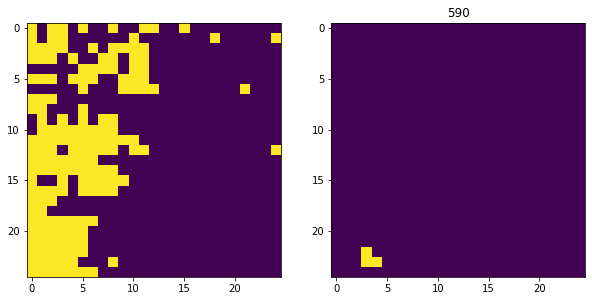

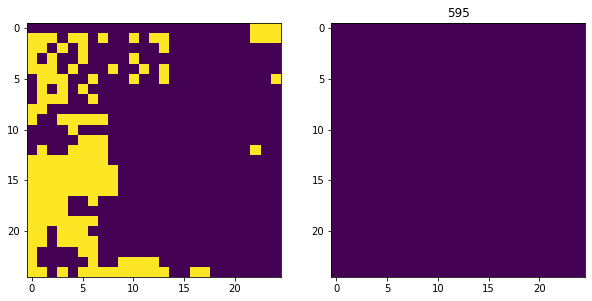

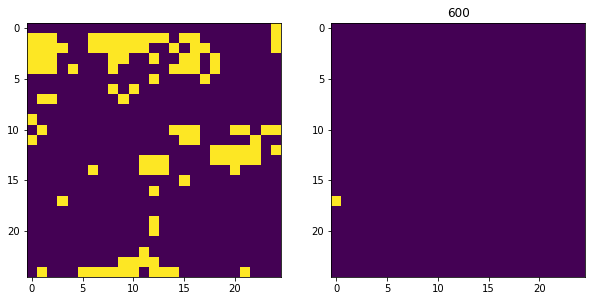

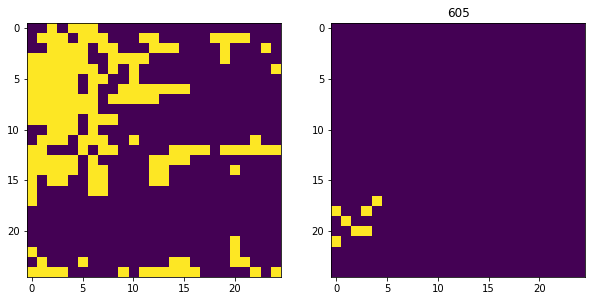

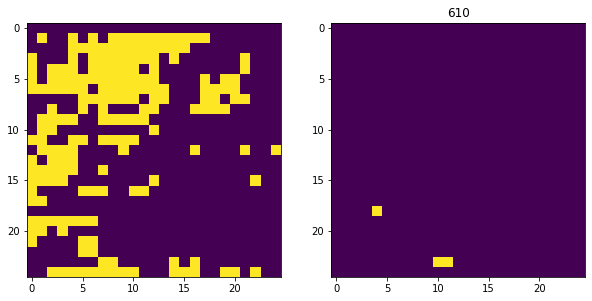

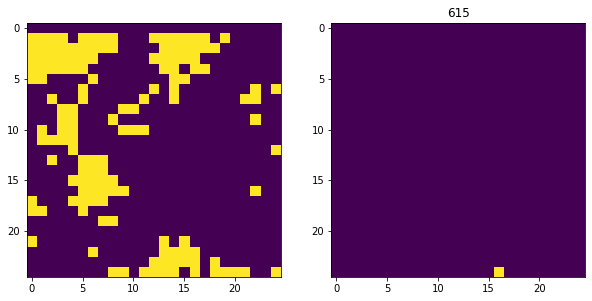

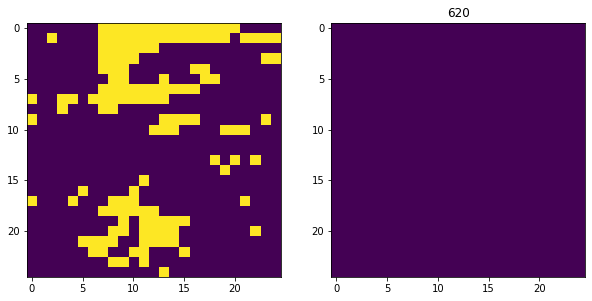

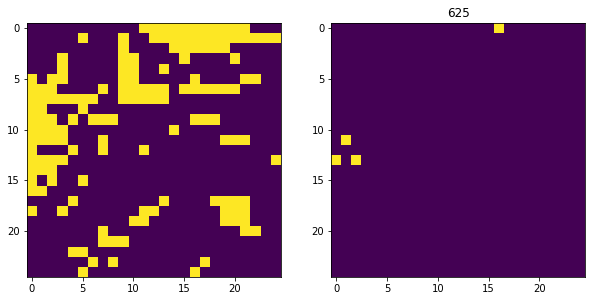

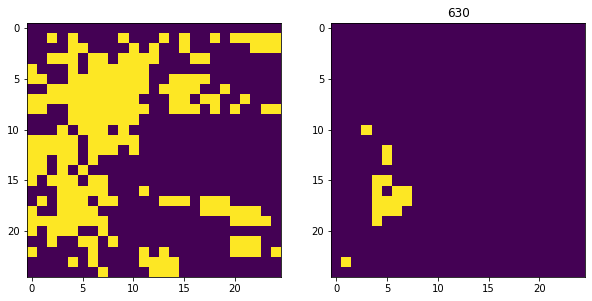

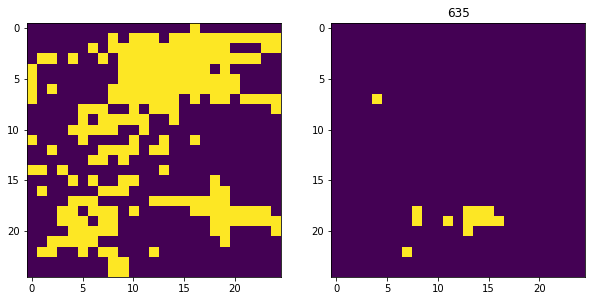

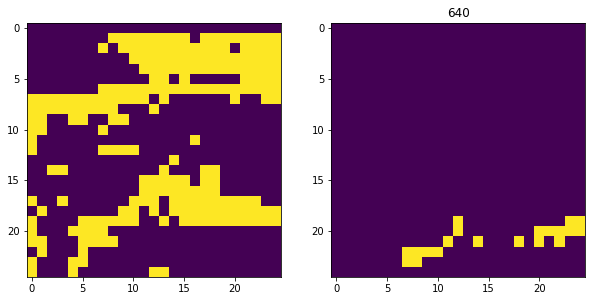

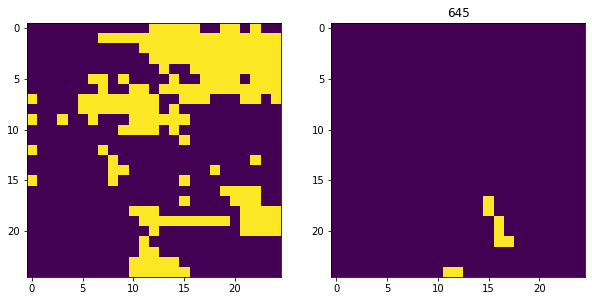

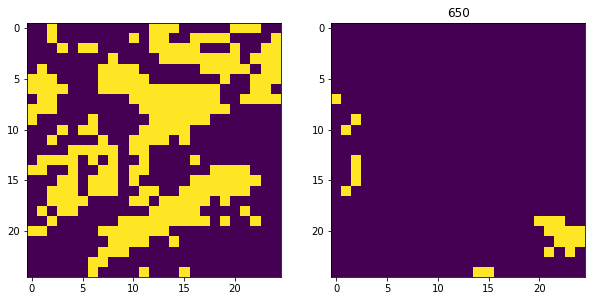

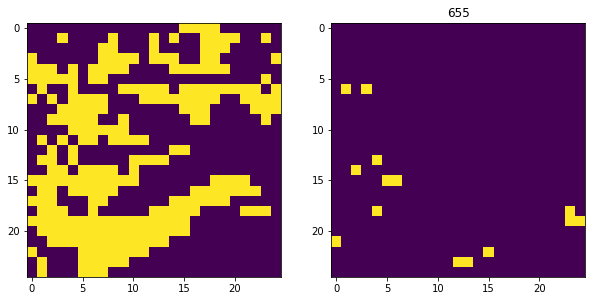

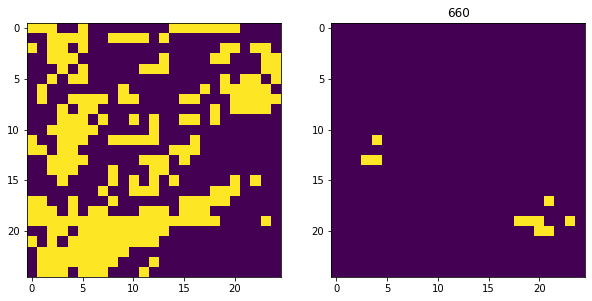

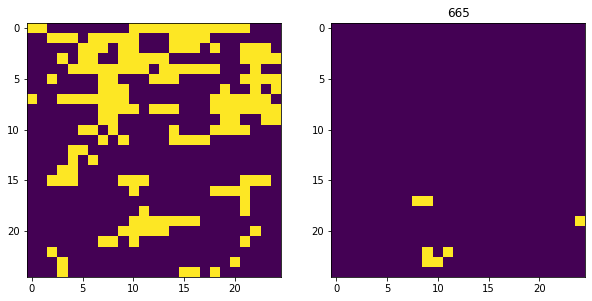

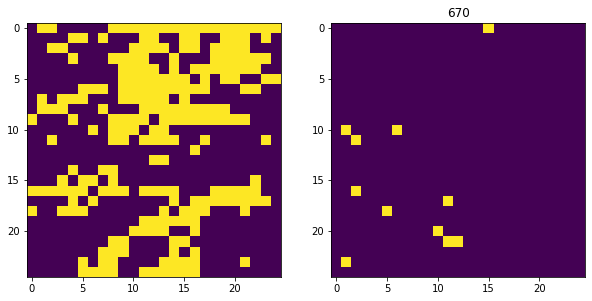

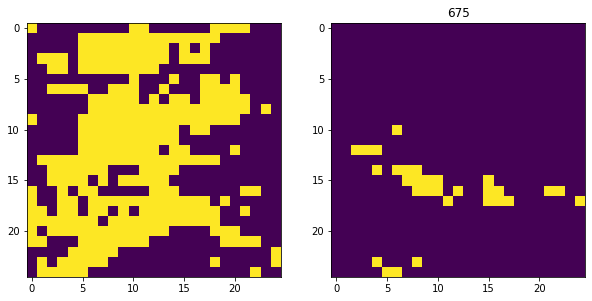

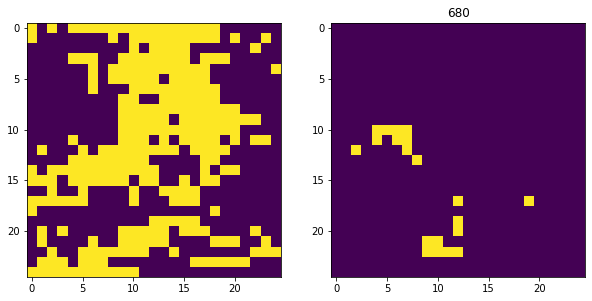

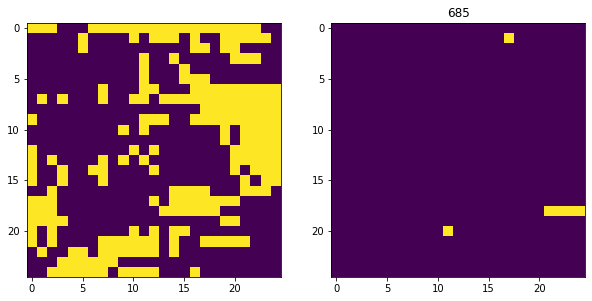

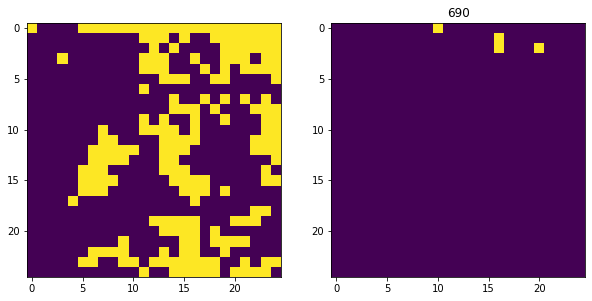

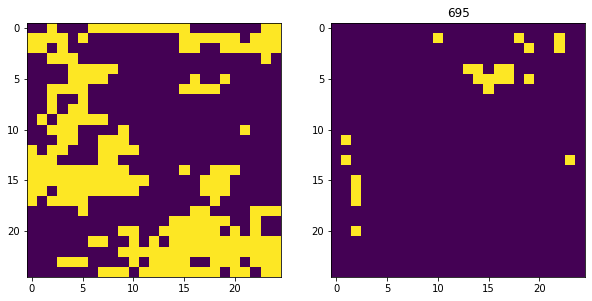

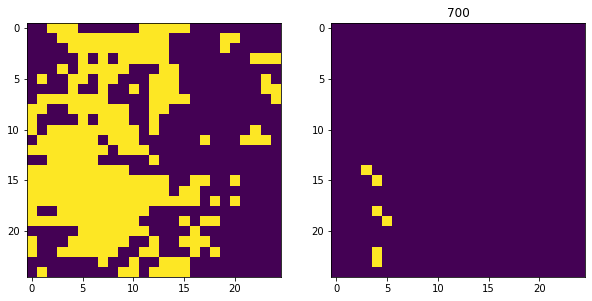

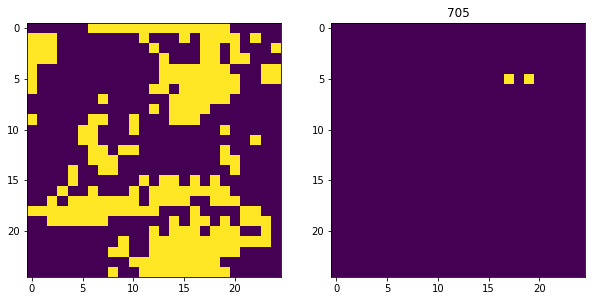

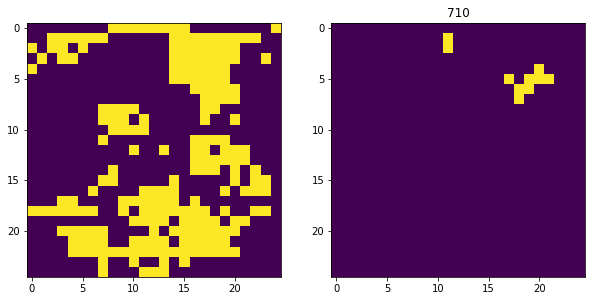

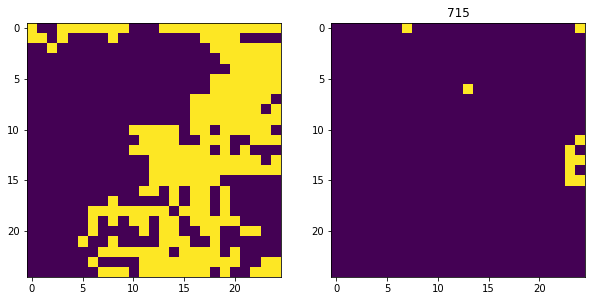

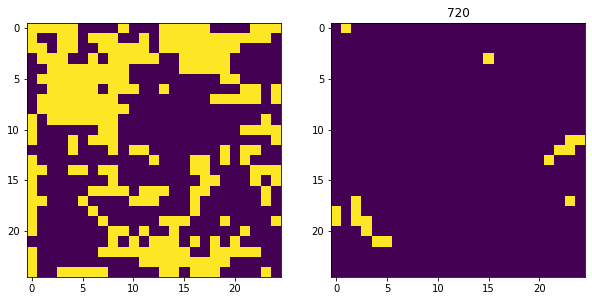

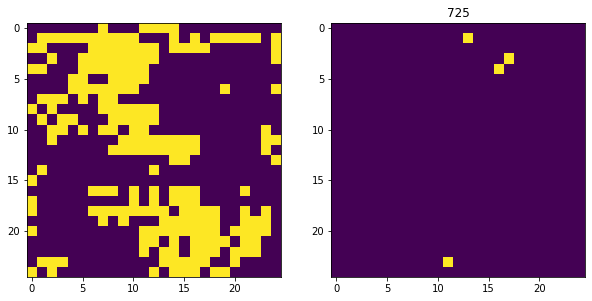

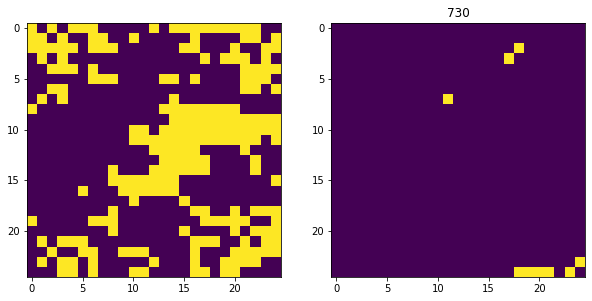

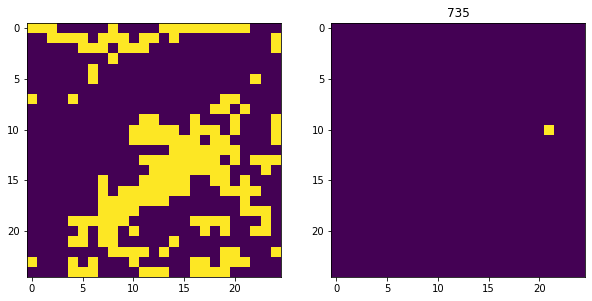

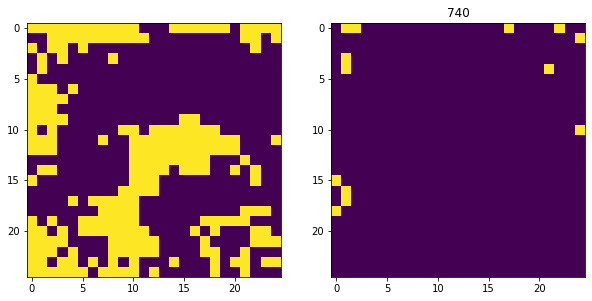

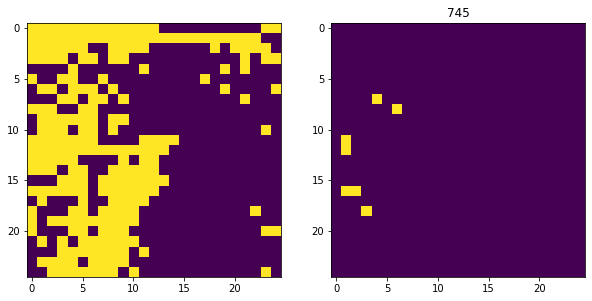

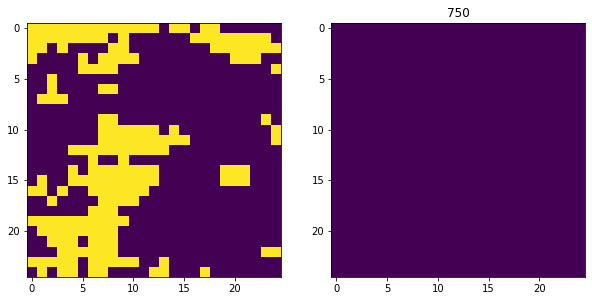

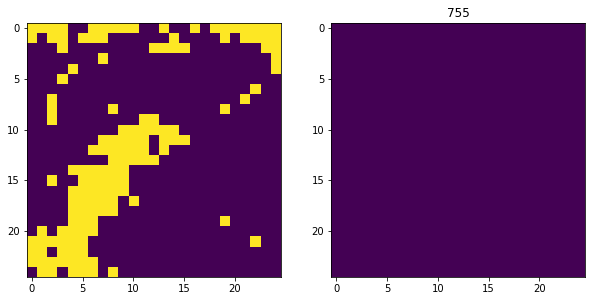

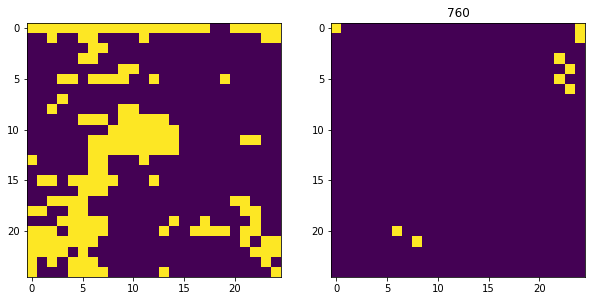

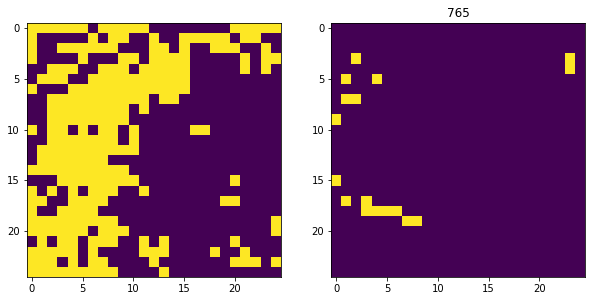

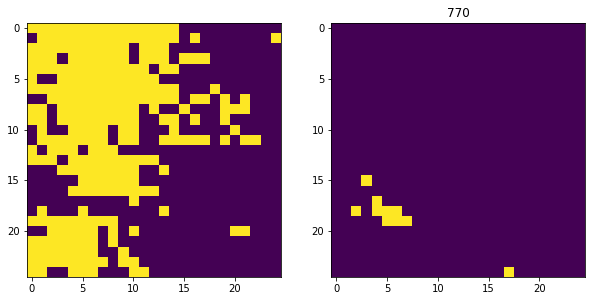

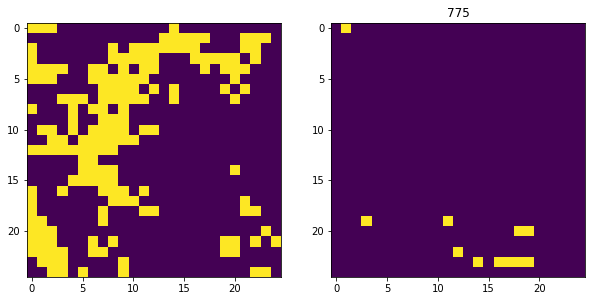

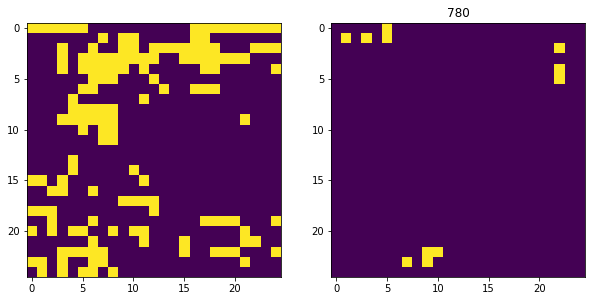

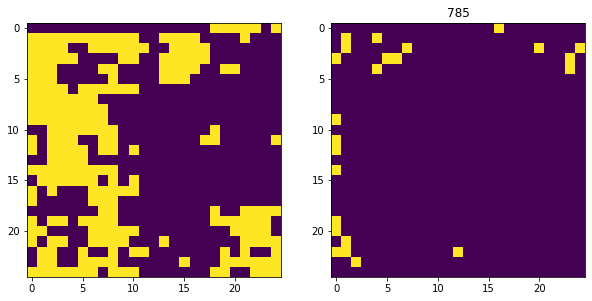

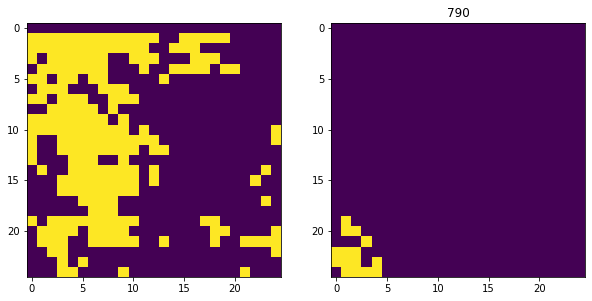

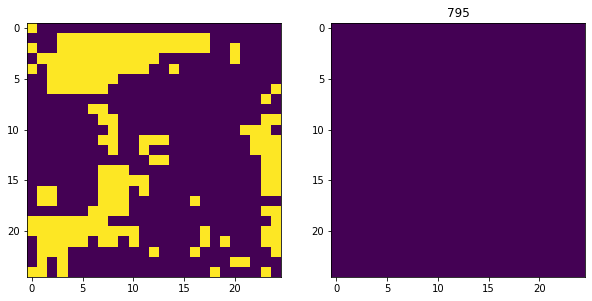

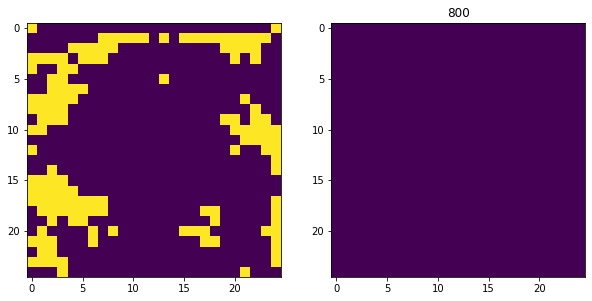

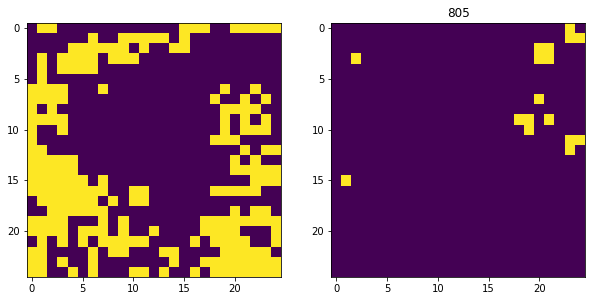

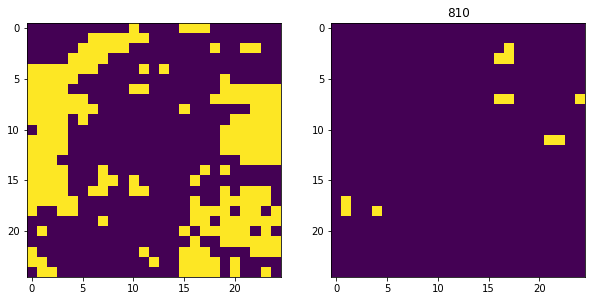

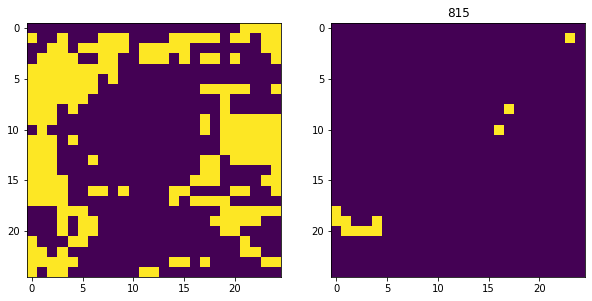

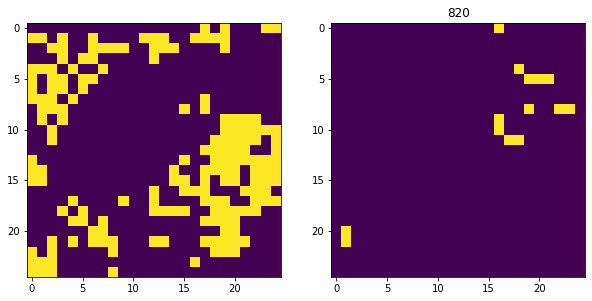

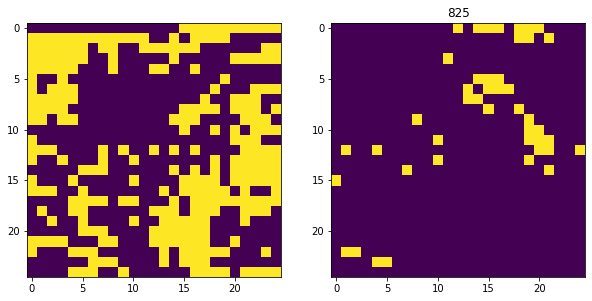

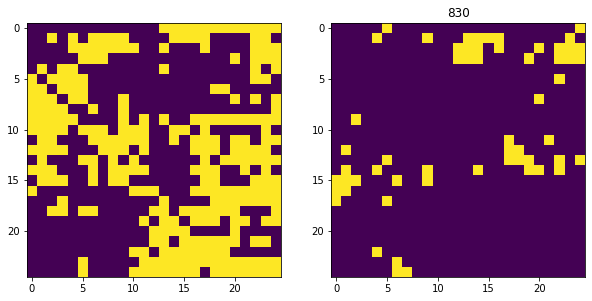

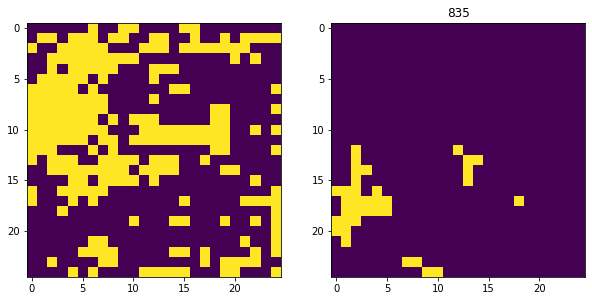

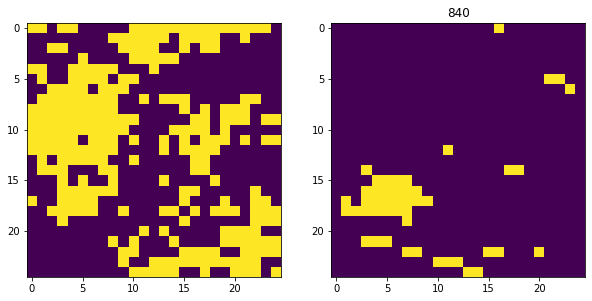

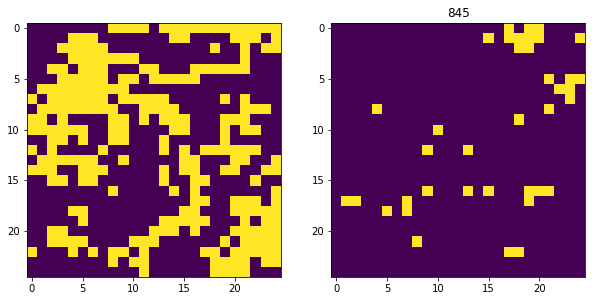

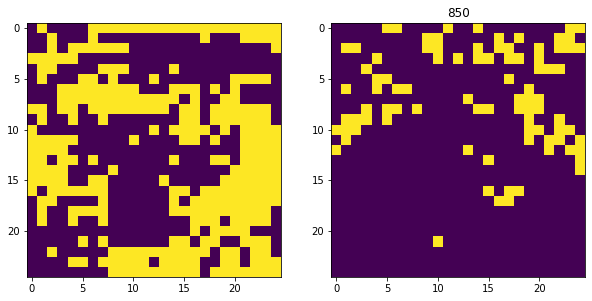

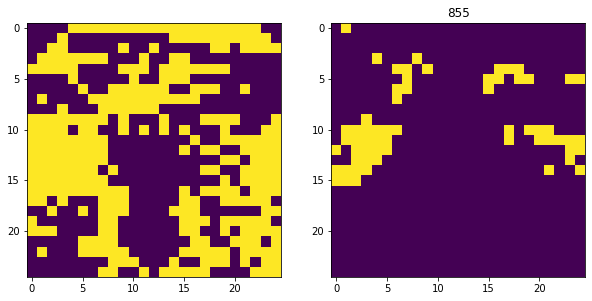

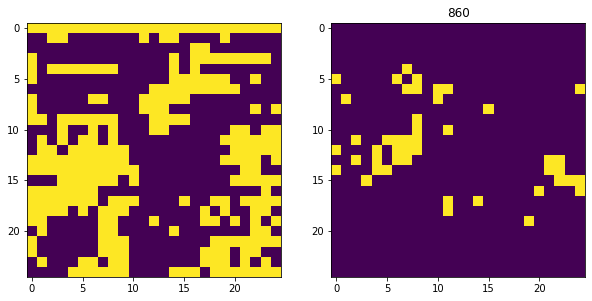

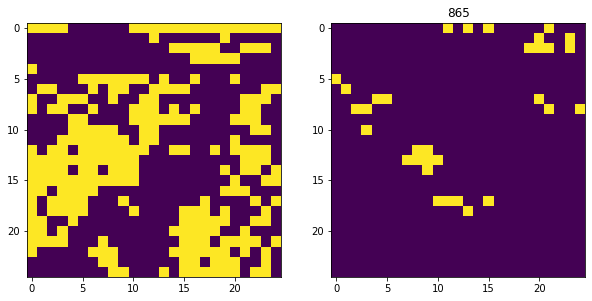

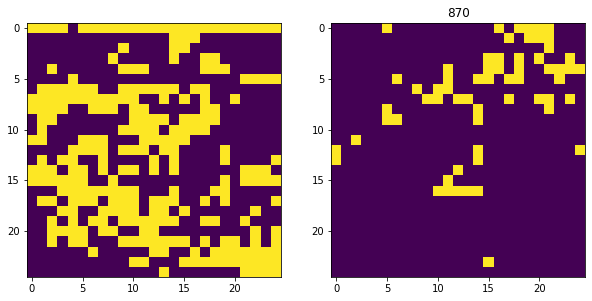

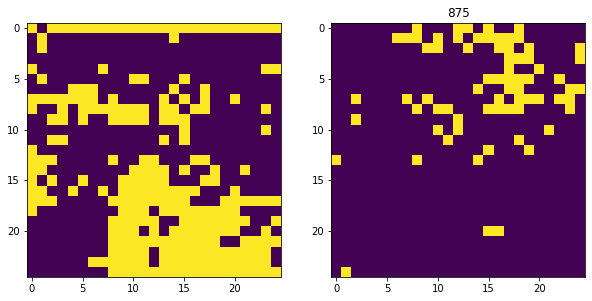

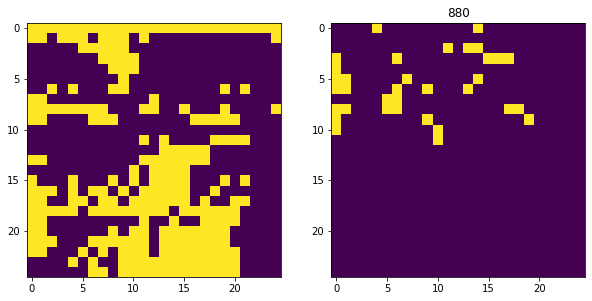

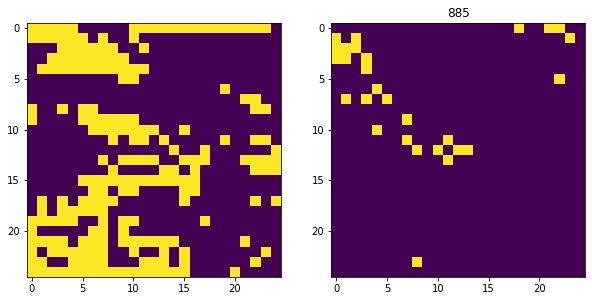

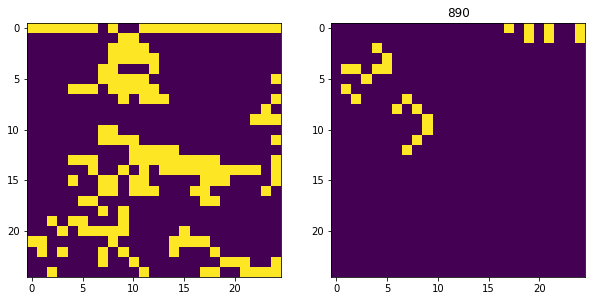

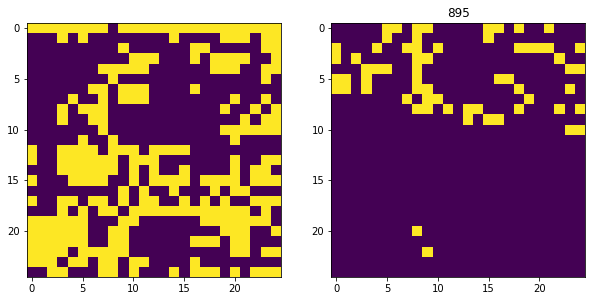

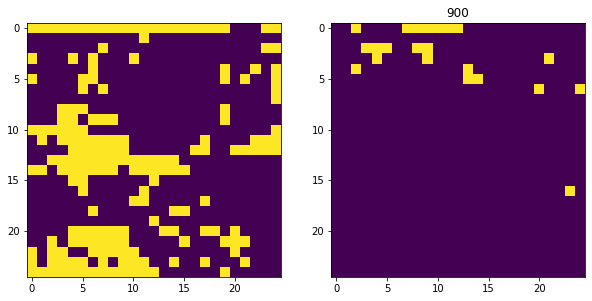

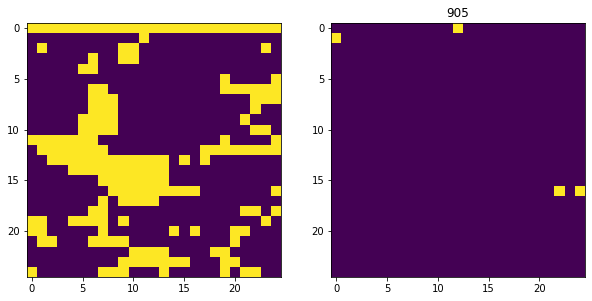

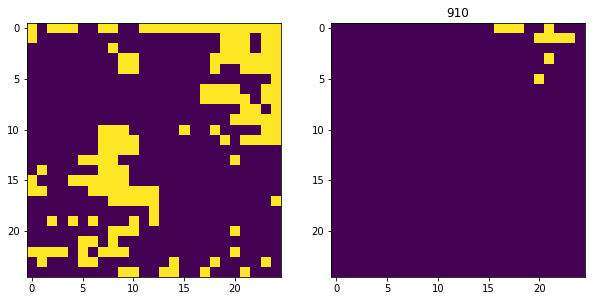

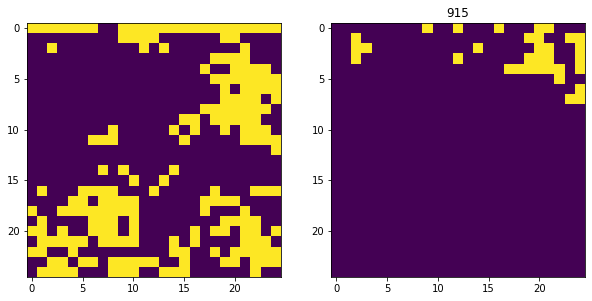

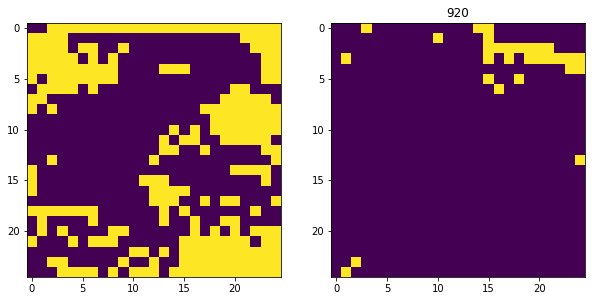

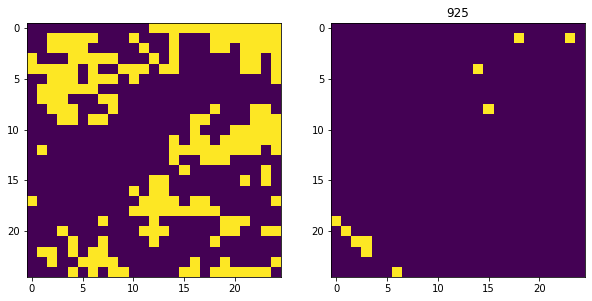

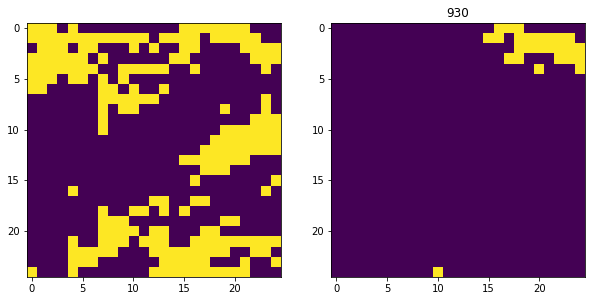

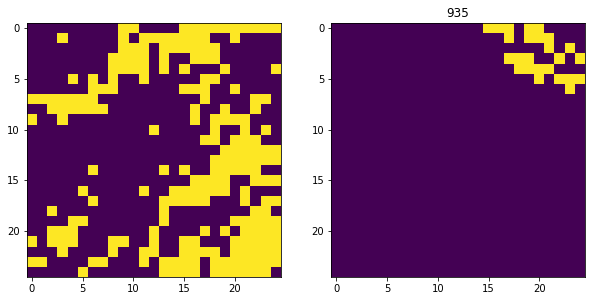

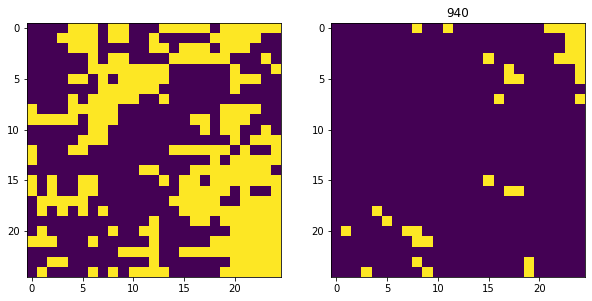

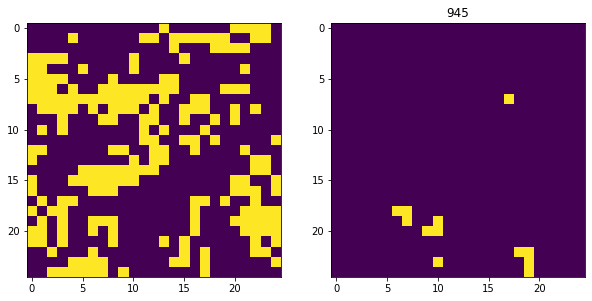

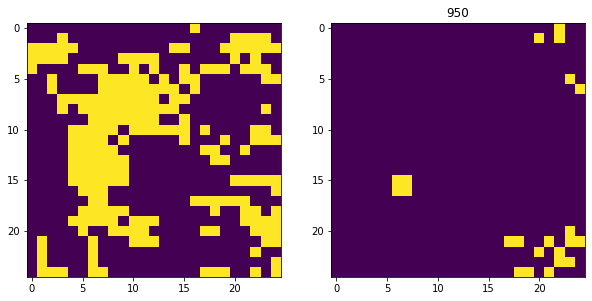

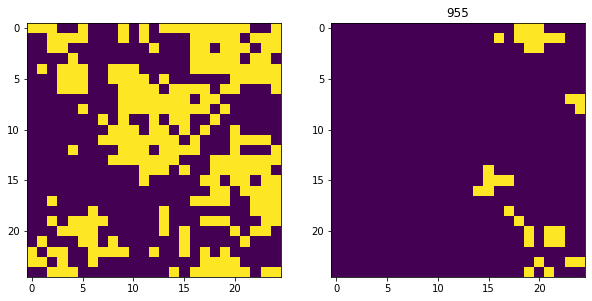

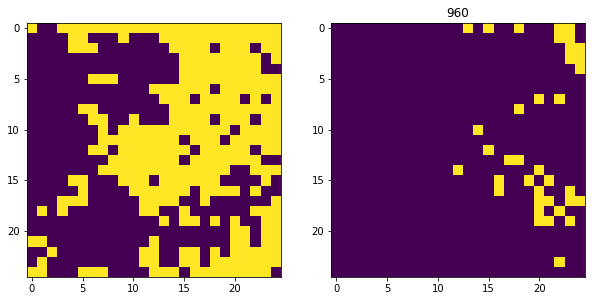

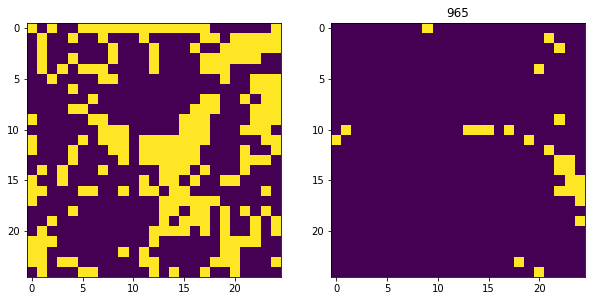

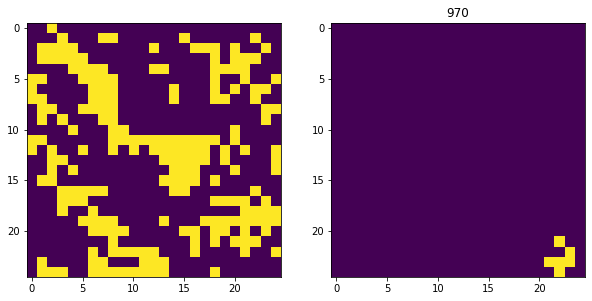

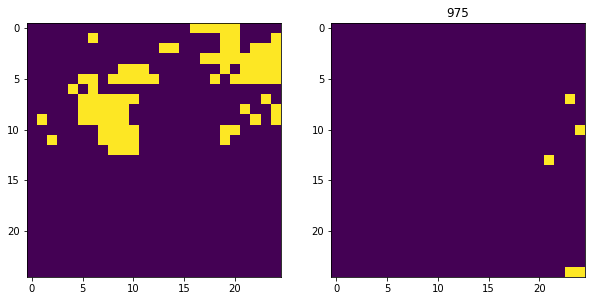

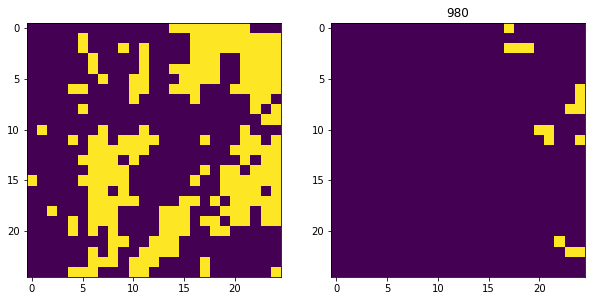

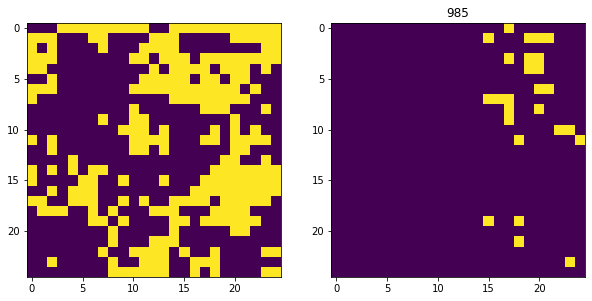

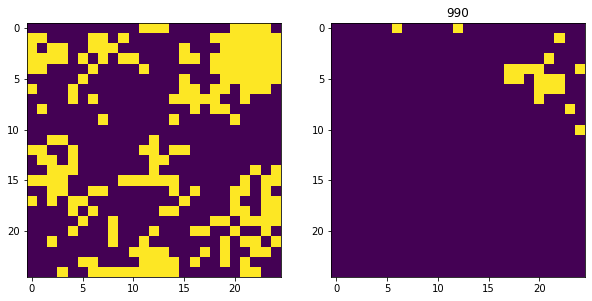

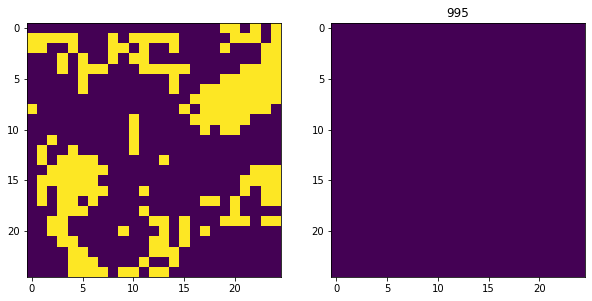

In [25]:
for i in range(0, 1000, 5):
    X=torch.tensor(GOSE[i]).float().cuda()
    Y=StageIV[i]
    pred,y_true=test_model('./Identification/results/like_qinghua/Epoch_31.pth.tar',X=X,Y=Y,step=14)
    
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(pred.reshape(25,25))
    plt.subplot(1, 2, 2)
    plt.imshow(y_true.reshape(25,25))
    plt.title(i)
    plt.show()
    plt.close()

/opt/anaconda3/envs/climate/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


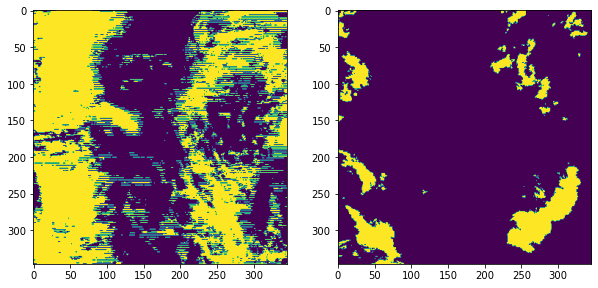

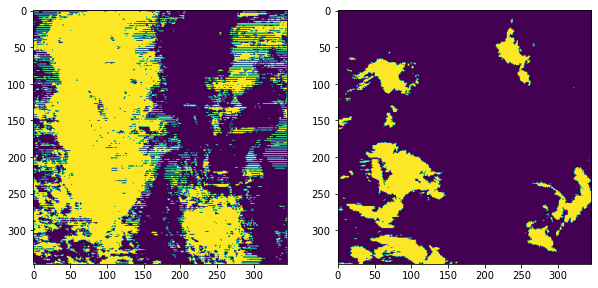

In [28]:
list = [335, 340]
for i in list:
    X=torch.tensor(GOSE[i]).float().cuda()
    Y=StageIV[i]
    pred,y_true=test_model('./Identification/results/like_qinghua/Epoch_31.pth.tar',X=X,Y=Y,step=1)
    
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(pred.reshape(346,346))
    plt.subplot(1, 2, 2)
    plt.imshow(y_true.reshape(346,346))
    plt.show()
    plt.close()

# 生成gif:输入-输出

In [2]:
train_path='/usr/commondata/weather/dataset_release/IR_dataset_QingHua/'
GOSE_train=np.load(train_path+'X_train_hourly.npz')['arr_0']
StageIV_train=np.load(train_path+'Y_train_hourly.npz')['arr_0']

In [64]:
import matplotlib.pyplot as plt
import torch
import matplotlib.patches as patches
import imp
import Estimation.models.Dataloader as Dataloader
import imageio
from pathlib import Path
imp.reload(Dataloader)


class GIFPloter():
    def __init__(self):
        self.root='/usr/data/gzy/climate/Precipitation_Estimation/Estimation/figs'
    
    def plot(self,x,y,X,Y,row,col,idx):
        ##大图
        fig= plt.figure(constrained_layout=True,figsize=(30, 25))
        gs = fig.add_gridspec(5,6)
#         X[:,row-14:row+15,col-14:col+15]=0
        H=X[0].shape[0]
        x_pos=col-15
        y_pos=row-15

        ax1=fig.add_subplot(gs[0:2, 0:2])
        ax1.imshow(X[0])
        rect = patches.Rectangle((x_pos,y_pos),29,29,linewidth=1,edgecolor='r',facecolor='none')
        ax1.add_patch(rect)

        ax2=fig.add_subplot(gs[0:2, 2:4])
        ax2.imshow(X[1])
        rect = patches.Rectangle((x_pos,y_pos),29,29,linewidth=1,edgecolor='r',facecolor='none')
        ax2.add_patch(rect)

        ax3=fig.add_subplot(gs[0:2, 4:6])
        ax3.imshow(X[2])
        rect = patches.Rectangle((x_pos,y_pos),29,29,linewidth=1,edgecolor='r',facecolor='none')
        ax3.add_patch(rect)

        ax4=fig.add_subplot(gs[2:4, 0:2])
        ax4.imshow(X[0]-X[1])
        rect = patches.Rectangle((x_pos,y_pos),29,29,linewidth=1,edgecolor='r',facecolor='none')
        ax4.add_patch(rect)

        ax5=fig.add_subplot(gs[2:4, 2:4])
        ax5.imshow(X[1]-X[2])
        rect = patches.Rectangle((x_pos,y_pos),29,29,linewidth=1,edgecolor='r',facecolor='none')
        ax5.add_patch(rect)

        ax6=fig.add_subplot(gs[2:4, 4:6])
        ax6.imshow(Y)
        rect = patches.Rectangle((x_pos,y_pos),29,29,linewidth=1,edgecolor='r',facecolor='none')
        ax6.add_patch(rect)


        ## 子图
        ax7=fig.add_subplot(gs[4, 0])
        ax7.imshow(x[0])

        ax8=fig.add_subplot(gs[4, 1])
        ax8.imshow(x[1])

        ax9=fig.add_subplot(gs[4, 2])
        ax9.imshow(x[2])

        ax10=fig.add_subplot(gs[4, 3])
        ax10.imshow(x[0]-x[1])

        ax11=fig.add_subplot(gs[4, 4])
        ax11.imshow(x[1]-x[2])

        ax12=fig.add_subplot(gs[4, 5])
        ax12.imshow(y)
        plt.title('{}'.format(y[14,14]))
        
        path=Path(self.root)
        path.mkdir(exist_ok=True,parents=True)
        plt.savefig(path/('small{}.png'.format(idx)))
        plt.close()
        

    def SaveGIF(self):
        path = self.root
        gif_images_path = os.listdir(path+'/')

        gif_images_path.sort()
        gif_images = []
        for i, path_ in enumerate(gif_images_path):
            print(path_)
            if '.png' in path_:
                if i % 4 == 0:
                    gif_images.append(imageio.imread(path+'/'+path_))
                    
        imageio.mimsave(path+'/'+"X2Y.mp4", gif_images, fps=1)



train_samples=Dataloader.IR_Split(     
                                X=GOSE_train, 
                                Y=StageIV_train,
                                task='estimation',
                                seed=2020,
                                shuffle=True,
                                win_size=14,
                                k_num=470000,
                                evaluate=True
                            ).split_dataset()

train_loader= Dataloader.CustomDatasetDataLoader(  
                                        X=GOSE_train, 
                                        Y=StageIV_train,
                                        batchSize=1024,
                                        selected_samples=train_samples,
                                        win_size=14,
                                        nThreads=1,
                                        seed=2020,
                                        )


Gif=GIFPloter()

idx=0
for xs,ys,Ts,rows,cols,Xs,Ys in train_loader:
    for N in range(xs.shape[0]):
        if (ys[N]>10).any():
            Gif.plot(xs[idx],ys[idx],Xs[idx],Ys[idx],rows[idx],cols[idx],idx)
            idx+=1
            print(idx)
        
        if idx==100:
            break
            
    if idx==100:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [66]:
import os
Gif.SaveGIF()

small0.png
small1.png
small10.png
small11.png
small12.png
small13.png
small14.png
small15.png
small16.png
small17.png
small18.png
small19.png
small2.png
small20.png
small21.png
small22.png
small23.png
small24.png
small25.png
small26.png
small27.png
small28.png
small29.png
small3.png
small30.png
small31.png
small32.png
small33.png
small34.png
small35.png
small36.png
small37.png
small38.png
small39.png
small4.png
small40.png
small41.png
small42.png
small43.png
small44.png
small45.png
small46.png
small47.png
small48.png
small49.png
small5.png
small50.png
small51.png
small52.png
small53.png
small54.png
small55.png
small56.png
small57.png
small58.png
small59.png
small6.png
small60.png
small61.png
small62.png
small63.png
small64.png
small65.png
small66.png
small67.png
small68.png
small69.png
small7.png
small70.png
small71.png
small72.png
small73.png
small74.png
small75.png
small76.png
small77.png
small78.png
small79.png
small8.png
small80.png
small81.png
small82.png
small83.png
small84.png
s

# test KL loss

In [44]:
import scipy.stats as stats
toCPU=lambda x: x.detach().cpu().numpy()
toCUDA=lambda x: torch.tensor(x).cuda()

In [251]:
import torch.nn as nn
import torch.nn.functional as F

class gaussian_kde(nn.Module):
    def __init__(self,h):
        super(gaussian_kde, self).__init__()
        self.h=h
    
    def ker(self,x,X):
        return torch.sum( torch.exp(-(x-X)**2/(2*self.h**2)) )
    
    def forward(self,x,X):
        P=[]
        for i in range(x.shape[0]):
            P.append(self.ker(x[i],X).view(1,-1))
        
        P=torch.cat(P).view(-1)
        P=P/torch.sum(P)
        return P

class KL_loss(nn.Module):
    def __init__(self,h,X_min,X_max,bins):
        super(KL_loss, self).__init__()
        self.X_min=X_min
        self.X_max=X_max
        self.bins=bins
        self.P=gaussian_kde(h)
        self.Q=gaussian_kde(h)
    
    def forward(self,pred,y_true):
        x=torch.linspace(self.X_min,self.X_max,self.bins)
        P=self.P(x,y_true)
        Q=self.Q(x,pred)
        KL=torch.sum(P*torch.log(P/Q))
        return KL,x,P,Q

In [258]:
KL=KL_loss(h=0.1,X_min=0,X_max=60,bins=100)

pred=nn.Parameter(torch.rand(1024)).cuda()*60
pred.retain_grad()
y_true=torch.rand(1024).cuda()*60

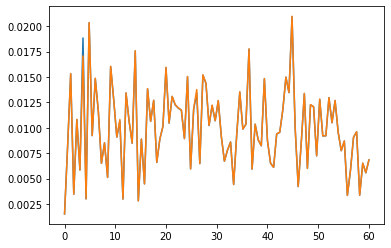

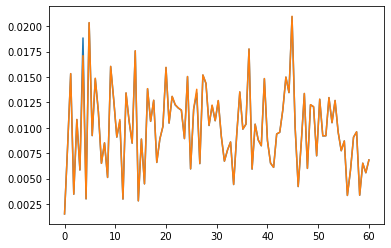

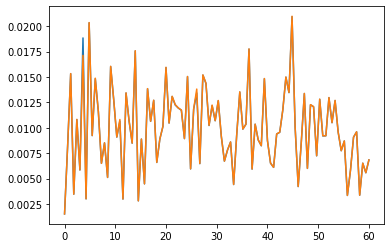

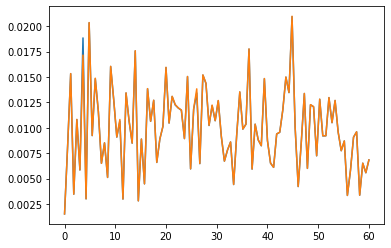

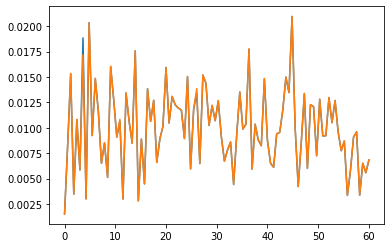

In [264]:
for epoch in range(50):
    kl,x,P,Q=KL(pred,y_true)
    kl.backward(retain_graph=True)
    
    pred.data=pred.data-1*pred.grad
    pred.grad.zero_()
    
    
    if epoch%10==0:
        plt.plot(x,toCPU(P)/np.sum(toCPU(P)))
        plt.plot(x,toCPU(Q)/np.sum(toCPU(Q)))
        plt.show()